 # Table of Contents
<div class="toc" style="margin-top: 1em;"><ul class="toc-item" id="toc-level0"><li><span><a href="http://localhost:8889/notebooks/PlotDistributions.ipynb#imports-and-functions" data-toc-modified-id="imports-and-functions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>imports and functions</a></span></li><li><span><a href="http://localhost:8889/notebooks/PlotDistributions.ipynb#Theory" data-toc-modified-id="Theory-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Theory</a></span></li><li><span><a href="http://localhost:8889/notebooks/PlotDistributions.ipynb#Load-and-plot" data-toc-modified-id="Load-and-plot-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Load and plot</a></span></li><li><span><a href="http://localhost:8889/notebooks/PlotDistributions.ipynb#Load-data" data-toc-modified-id="Load-data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Load data</a></span></li></ul></div>

In [888]:
from IPython.core.display import display,HTML
display(HTML("<style>.container {width:95% !important;} </style>"))
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# imports and functions

In [889]:
import matplotlib as mpl
mpl.use("pgf")
pgf_with_rc_fonts = {
   "pgf.rcfonts" : False
}
mpl.rcParams.update(pgf_with_rc_fonts)
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import rcParams
import glob
import numpy as np
from scipy import constants as const
import datetime as dt

/home/tmerten/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [1274]:


# plt.pgf.rcfonts= False
def plotEmit(col='ex',nmean=10,save=False,savefilename=None,m=None,timeratio=1.0,legendlabels=[],n=-1):
    plt.rc('text', usetex=True)
    with plt.style.context(['seaborn-poster']):
        for fe in femit[:n]:
            plt.plot(fe.rolling(nmean).mean().dropna()['Turn']*timeratio*800e-9*1e3,fe.rolling(nmean).mean().dropna()[col])
#             fe.rolling(nmean).mean().dropna().plot(x='Turn',y=col)

        t = int(fe.tail(1)['Turn'].values[0]*timeratio*800e-9*1e3)
        
        # radiation damping equilibria
        if col=='ex':
            plt.plot(range(0,t,t-1), [8.66796e-09]*2)
            plt.ylabel('$\epsilon_x$')
            
        if col=='ey':
            plt.plot(range(0,t,t-1), [2.5505e-13]*2)
            plt.ylabel('$\epsilon_y$')
        if col=='sigs':
            plt.plot(range(0,t,t-1), [eta * const.c/ (0.007 *omega0)*np.sqrt(1.65e-15*const.c)/const.c]*2)
            plt.ylabel('$\sigma_s$')
        if col=='sige':
            plt.plot(range(0,t,t-1), [np.sqrt(1.6e-15*const.c)]*2)
            plt.ylabel('$\delta$')
    plt.ylim(ymin=0, ymax = fe.rolling(nmean).mean().dropna()[col].max() * 1.2) 
    plt.grid()
    plt.title('Radiation Damping to Equilibrium')
    plt.xlabel('Time [ms]')
    plt.legend(legendlabels)
    if m:
        plt.ylim(0,m)
    if save:
        plt.savefig(savefilename + ".pdf" )
        plt.savefig(savefilename + ".pgf")
    plt.show()
    
def extractEqui(nmean):
    ex =[]
    ey= []
    sigs = []
    for f in femit:
        ex.append(f.rolling(nmean).mean().dropna().tail(1)['ex'].values[0])
        ey.append(f.rolling(nmean).mean().dropna().tail(1)['ey'].values[0])
        sigs.append(f.tail(1)['sigs'].values[0])
    return ex, ey, sigs

In [384]:
from sqlalchemy import create_engine
from sqlalchemy import inspect
import os
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker
from sqlalchemy import Column, Integer, String, DateTime, Float
from sqlalchemy import exists

dbpath = '/home/tmerten/data/IBS/simadata/'
dbfile = 'bessyII.db'

if not os.path.exists( dbpath ):
    os.mkdir( dbpath )
    
engine = create_engine("sqlite:///" +  dbpath + dbfile )

Base = declarative_base()

class Intensity(Base):
    __tablename__ = 'intensity'
    id = Column(Integer, primary_key=True)
    simid = Column(Integer)
    date = Column(DateTime, default=dt.datetime.utcnow)
    Turn = Column(Integer)
    NMacro = Column(Integer)
    Current = Column(Float)
    NReal = Column(Float)
    NRealLost = Column(Float)
    Ttou = Column(Float)
    
class Emit(Base):
    __tablename__ = 'emit'
    id = Column(Integer, primary_key=True)
    simid = Column(Integer)
    date = Column(DateTime, default=dt.datetime.utcnow)
    Turn = Column(Integer)
    ex = Column(Float)
    sigpx = Column(Float)
    ey = Column(Float)
    sigpy = Column(Float)
    sigs = Column(Float)
    sige = Column(Float)

class Ibs(Base):
    __tablename__ = 'ibs'
    id = Column(Integer, primary_key=True)
    simid = Column(Integer)
    date = Column(DateTime, default=dt.datetime.utcnow)
    Turn = Column(Integer)
    Tex = Column(Float)
    Tey = Column(Float)
    Tp = Column(Float)
    

Base.metadata.create_all(engine)
inspector = inspect(engine)
Session = sessionmaker(bind=engine)
session = Session()

# Get table information
print(inspector.get_table_names())

# Get column information
# print(inspector.get_columns('intensity'))

pd.read_sql_table('intensity', engine)
pd.read_sql_table('emit', engine)
# pd.read_sql_table('ibs', engine)
#      def __repr__(self):
#         return "<User(name='%s', fullname='%s', password='%s')>" % (
#                              self.name, self.fullname, self.password)

# engine.execute('''DROP TABLE ibs''')

def addFrameToDb(TableNameObject,TableName,SimId,frame):
    ret = session.query(exists().where(TableNameObject.simid==SimId)).scalar()
    if ret:
        print('simid already exist - change it')
    else:
        try:
            collist = []
            for d in inspector.get_columns(TableName):
                collist.append(d['name'])
#             print(collist[1:])
            print('adding to database')
            frame['date'] = dt.datetime.now()
            frame['simid'] = SimId
            frame = frame.loc[:,collist]
#             print(frame.columns)
            frame.to_sql(name=TableName,con=engine, if_exists = 'append', index=False)
        except:
            print('adding to database failed')

In [25]:
def calccurrent(n,frev):
    return const.elementary_charge * n * frev

In [27]:
calccurrent(8e10,1.25e6)

0.016021766208

In [1122]:
    # betas at pinhole
    #  	BETX 	BETY
    #  	0.438597 	21.94217
betx= 0.438597
bety = 21.94217

# Theory

In [4]:
eta = 7.e-4
h = 400
phis =-.124

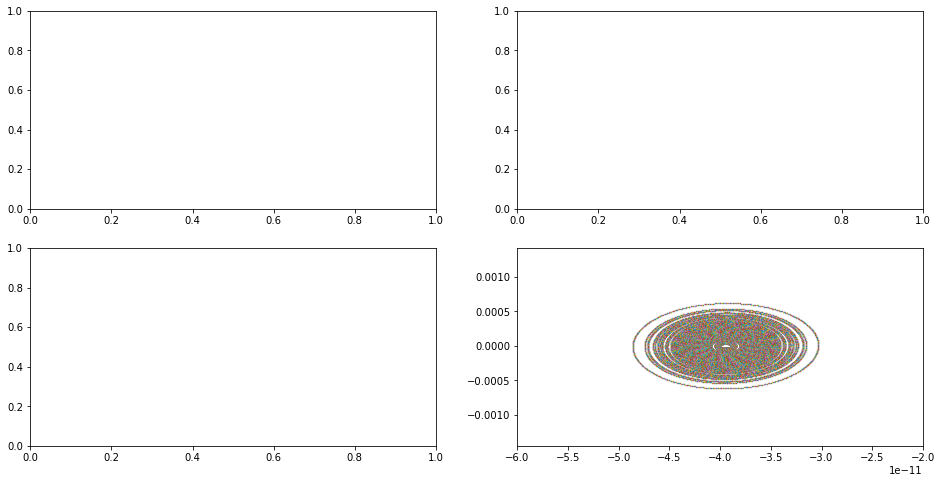

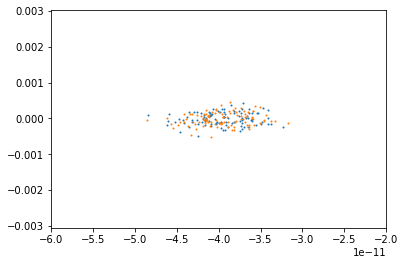

In [43]:
phi = dfs1[0][4] * 400 * 2 * np.pi * (1.25e6) #np.random.normal(-0.124,1,10)
# print(phi)
delta = dfs1[0][5] # np.random.normal(0.0,0.002,10) # np.array([0.0] * len(phi)) 
def dphi(h,eta,delta):
    return -2 * np.pi * h * eta * delta

def ddelta(v,E,phi,phis):
    return v/E*(np.sin(phi)-np.sin(phis))

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16,8))
# phi=0.12
# delta =0
# axes[0,0].hist(phi.values,bins=20)
# axes[0,1].hist(delta.values,bins=20)

phis=-0.124
for i in range(0,1000):
    axes[1,1].scatter(phi/(400 * 2 * np.pi * (1.25e6)), delta ,s=.11)
    phi =phi+dphi(h,eta,delta)
    delta =delta + ddelta(1.4e6,1.7e9,phi,phis)
#     print( ddelta(1.4e6,1.7e9,phi,phis))
axes[1,1].set_xlim(-.6e-10,-.2e-10)
# axes[1,1].set_ylim(-2e-4,2e-4)
plt.show()

plt.scatter(dfs1[0][4],dfs1[0][5], s=1)
plt.scatter(phi/(400 * 2 * np.pi * (1.25e6)),delta,s=1)
plt.xlim(-6e-11,-.2e-10)
plt.show()



In [1529]:
fi0 = np.deg2rad(0.0)
fi=0.00
points=[]
dEOszi =[]
h=400
alpha=7.0e-4
for j in range(0,31):
longDy = [[],[]]
fi = np.deg2rad(-90.0 + 21*j)
dE = 0.00000
#
fi = 0.0
#
dE = 0.0 - (0.0001*j)
for i in range(0,600):
fi = fi - 2*np.pi*h*alpha * dE
if (j<13):
dE = dE + 1/1.7e9* 1.5e6 * (np.sin(fi) - np.sin(fi0))
if (j>12):
dE = dE + 1/1.7e9* 32.0e6 * (np.sin(fi) - np.sin(fi0))

longDy[0].append(fi/2/np.pi/500.0e6)
longDy[1].append(dE)
if j == 2:
points.append(i)
dEOszi.append(fi)
plt.plot(longDy[0], longDy[1], "-")
plt.xlabel('time / s', fontsize=12)
plt.ylabel('relative energy deviation $\ \delta$', fontsize=12)
plt.tight_layout()
plt.grid()
plt.savefig('LongDym.png', dpi=300)
plt.show()
#
plt.plot(points,dEOszi,"o")


IndentationError: expected an indented block (<ipython-input-1529-d1d8b4a4ca79>, line 8)

In [454]:
glob.glob('STE_Emittances_0_05_02_2018.dat')

['STE_Emittances_0_05_02_2018.dat']

# Load and plot


nvcc -ccbin clang-3.8 -lstdc++ -lm  STE.cu STE_ReadInput_double.cpp STE_TFS_double.cu STE_Radiation_double.cu STE_Longitudinal_Hamiltonian_double.cu STE_Synchrotron_double.cu STE_ReadBunchFiles_double.cu STE_IBS_double.cu 
STE_Bunch_double.cu -run

In [1121]:
lastid = pd.read_sql_table('emit', engine).tail(1).simid.values[0]
for i in range(1,len(fsint)):
    f1 = fsint[i]
    f2 = femit[i]
    f3 = fibs[i]
    simid = lastid+i
    addFrameToDb(Intensity,'intensity',simid,f1)
    addFrameToDb(Emit,'emit',simid,f2)
    addFrameToDb(Ibs,'ibs',simid,f3)
   

adding to database
adding to database
adding to database


In [494]:
dff = pd.read_sql_table('intensity', engine)
dff[dff['simid']==3]

,id,simid,date,Turn,NMacro,Current,NReal,NRealLost,Ttou
4002,4003,3,2018-02-16 16:48:49.360926,0,1000,0.002001,1.000000e+10,0.0,0.0
4003,4004,3,2018-02-16 16:48:49.360926,1,1000,0.002001,1.000000e+10,0.0,0.0
4004,4005,3,2018-02-16 16:48:49.360926,2,1000,0.002001,1.000000e+10,0.0,0.0
4005,4006,3,2018-02-16 16:48:49.360926,3,1000,0.002001,1.000000e+10,0.0,0.0
4006,4007,3,2018-02-16 16:48:49.360926,4,1000,0.002001,1.000000e+10,0.0,0.0
4007,4008,3,2018-02-16 16:48:49.360926,5,1000,0.002001,1.000000e+10,0.0,0.0
4008,4009,3,2018-02-16 16:48:49.360926,6,1000,0.002001,1.000000e+10,0.0,0.0
4009,4010,3,2018-02-16 16:48:49.360926,7,1000,0.002001,1.000000e+10,0.0,0.0
4010,4011,3,2018-02-16 16:48:49.360926,8,1000,0.002001,1.000000e+10,0.0,0.0
4011,4012,3,2018-02-16 16:48:49.360926,9,1000,0.002001,1.000000e+10,0.0,0.0


# Load data

In [1327]:
filelimit = 27

gamma   = 3326.817037
betar   = np.sqrt( 1 - ( 1 / gamma**2 ) )
trev    = 240.00839 / ( betar * const.c )
frev    = 1/ trev
h0      = 400
v0      = .5e6
gammatr = 37.841888
eta     = ( 1/ gammatr**2 ) - ( 1 / gamma**2 )
p0      = 1.7e9
phis    = -np.arcsin(172443/v0)
nus     = np.sqrt( abs( h0 * eta * (-1) ) / ( 2 * np.pi * betar * p0 ) * ( v0 * np.cos(phis) ) )
omega0  = 2 * np.pi / trev
sigs    = 0.005
sige    = nus * omega0 * sigs / ( const.c * eta)


# day = '14'
# bucket0files = glob.glob('Distribution_bucket_0_' + day +'*000.dat')
# bucket1files = glob.glob('Distribution_bucket_1_' + day +'*000.dat')
# bucket2files = glob.glob('Distribution_bucket_2_' + day +'*000.dat')
# bucket3files = glob.glob('Distribution_bucket_3_' + day +'*000.dat')
# bucket4files = glob.glob('Distribution_bucket_4_' + day +'*000.dat')
# bucket5files = glob.glob('Distribution_bucket_5_' + day +'*000.dat')
# bucket6files = glob.glob('Distribution_bucket_6_' + day +'*000.dat')
# bucket7files = glob.glob('Distribution_bucket_7_' + day +'*000.dat')

day = '21'
bucket0files = glob.glob('Distribution_bucket_0_' + day +'*.dat')
bucket1files = glob.glob('Distribution_bucket_1_' + day +'*.dat')
bucket2files = glob.glob('Distribution_bucket_2_' + day +'*.dat')
bucket3files = glob.glob('Distribution_bucket_3_' + day +'*.dat')
bucket4files = glob.glob('Distribution_bucket_4_' + day +'*.dat')
bucket5files = glob.glob('Distribution_bucket_5_' + day +'*.dat')
bucket6files = glob.glob('Distribution_bucket_6_' + day +'*.dat')
bucket7files = glob.glob('Distribution_bucket_7_' + day +'*.dat')

bucket0files.sort()
bucket1files.sort()
bucket2files.sort()
bucket3files.sort()
bucket4files.sort()
bucket5files.sort()
bucket6files.sort()
bucket7files.sort()

dfs1 = [pd.read_csv(file, delim_whitespace=True, header=None) for file in bucket0files[:filelimit]]
dfs2 = [pd.read_csv(file, delim_whitespace=True, header=None) for file in bucket1files[:filelimit]]
dfs3 = [pd.read_csv(file, delim_whitespace=True, header=None) for file in bucket2files[:filelimit]]
dfs4 = [pd.read_csv(file, delim_whitespace=True, header=None) for file in bucket3files[:filelimit]]
dfs5 = [pd.read_csv(file, delim_whitespace=True, header=None) for file in bucket4files[:filelimit]]
dfs6 = [pd.read_csv(file, delim_whitespace=True, header=None) for file in bucket5files[:filelimit]]

intfiles  = glob.glob('STE_Intensity_*'+day+'_02_2018.dat')
ibsfiles  = glob.glob('STE_IBS_LifeTimes_*'+day+'_02_2018.dat')
emitfiles = glob.glob('STE_Emittances_*'+day+'_02_2018.dat')


intfiles.sort()
ibsfiles.sort()
emitfiles.sort()

fsint = [pd.read_csv(file, delim_whitespace=True) for file in intfiles[:filelimit]]
fibs  = [pd.read_csv(file, delim_whitespace=True) for file in ibsfiles[:filelimit]]
femit = [pd.read_csv(file, delim_whitespace=True) for file in emitfiles[:filelimit]]

dcemit = {int(i.split('_')[2]) : i for i in emitfiles }
dcemit
femit = [pd.read_csv(dcemit[i], delim_whitespace=True) for i in range(len(dcemit))]



Rad min

In [1219]:
def bu(val):
    return '{:6.4f}'.format((0.279 + (0.27-0.279)/(32.515203828386205- 33.95948563)*(val - 33.95948563 )))

In [1250]:
bu(42)

'0.3291'

In [975]:
np.sqrt(3.8319e-13 * 3326.817037**2 * 0.002749827204 / (1-0.009159564232/1.489302122)/1.489302122 * 0.46)

6.0202682833930963e-05

In [1164]:
simvals = []

In [1279]:
s*const.c

TypeError: can't multiply sequence by non-int of type 'float'

In [1306]:
x,y,s = extractEqui(nmean=10)
print('x : ',np.sqrt(np.array(x)*betx)*1e6)
print('y : ',np.sqrt(np.array(y)*bety)*1e6)
print('s : ',(np.array(s)*const.c))

x :  [ 63.20375213  62.0444492 ]
y :  [ 12.30319415  36.09264448]
s :  [ 0.00349324  0.00315448]


In [1254]:

simvals.append([ (np.sqrt(np.array(x)*betx)*1e6)[0] , (np.sqrt(np.array(y)*bety)*1e6)[0] , (np.sqrt(np.array(s)*const.c))[0] ])

In [1255]:
lastid = pd.read_sql_table('emit', engine).tail(1).simid.values[0]
for i in range(1,len(fsint)):
    f1 = fsint[i]
    f2 = femit[i]
    f3 = fibs[i]
    simid = lastid+i
    addFrameToDb(Intensity,'intensity',simid,f1)
    addFrameToDb(Emit,'emit',simid,f2)
    addFrameToDb(Ibs,'ibs',simid,f3)
    
simvalsbak = simvals

adding to database
adding to database
adding to database


In [1267]:
(35e-6)**2/bety

5.582857119418908e-11

In [1249]:
print(lastid)

44


In [1261]:
fsim = pd.DataFrame(simvals)
fsim.columns = ['sigx','sigy','sigs']

In [1281]:
fsim['sigs'] = fsim['sigs']**2

In [1264]:
fsim['npart'] = [1e10,2e10,3e10,4e10,5e10,6e10,6.5e10]

In [1296]:
fsim.to_csv('/home/tmerten/data/IBS/simadata/emit_evolution_range_1_6p5_mA.csv', sep='\t',index=False)

In [1268]:
(32.515204e-6)**2/bety

4.818295050861496e-11

In [1295]:
fsim

,sigx,sigy,sigs,npart
0,62.171354,32.515204,0.002788,1.000000e+10
1,62.522194,33.013917,0.002850,2.000000e+10
2,62.803842,33.959486,0.002898,3.000000e+10
3,63.020390,35.426889,0.002935,4.000000e+10
4,63.183142,37.494122,0.002963,5.000000e+10
5,63.319590,39.544934,0.002986,6.000000e+10
6,63.377446,40.570744,0.002997,6.500000e+10


In [1256]:
simvals

[[62.171354261701559, 32.515203828386205, 0.052802346983325275],
 [62.522193738719686, 33.013916901150935, 0.053389022445110006],
 [62.803841903700473, 33.959485630059284, 0.053834168284488615],
 [63.020389710759488, 35.426889178501156, 0.054178085591440196],
 [63.183142177348167, 37.49412166675063, 0.054433737110484895],
 [63.319589704435074, 39.544933681203709, 0.054646351025153181],
 [63.377446398533614, 40.570744384334404, 0.054740985686585877]]

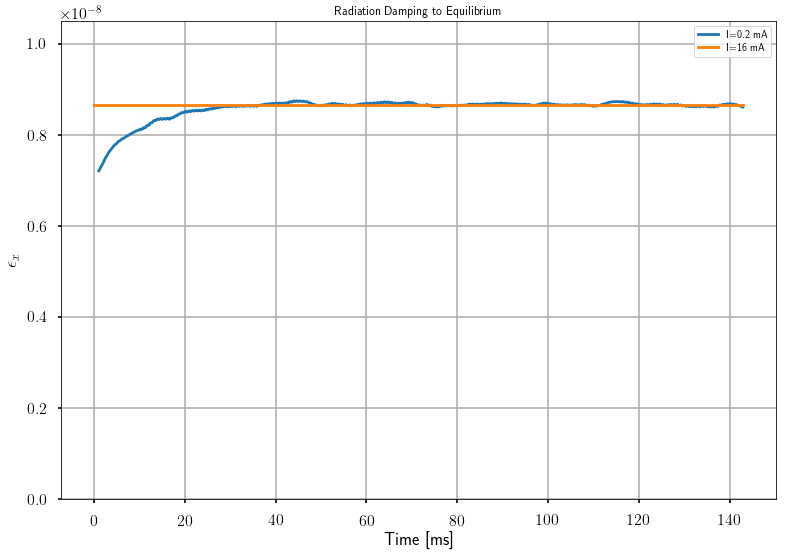

In [1328]:
plotEmit(n=1,col='ex',nmean=10,timeratio=300, legendlabels=['I=0.2 mA','I=16 mA','Rad Equil'],save=False, savefilename='/home/tmerten/LATEX/Presentations/IPAC18/RAD_ex')

In [1284]:
np.sqrt((80e-12 * bety))

4.189717890264212e-05

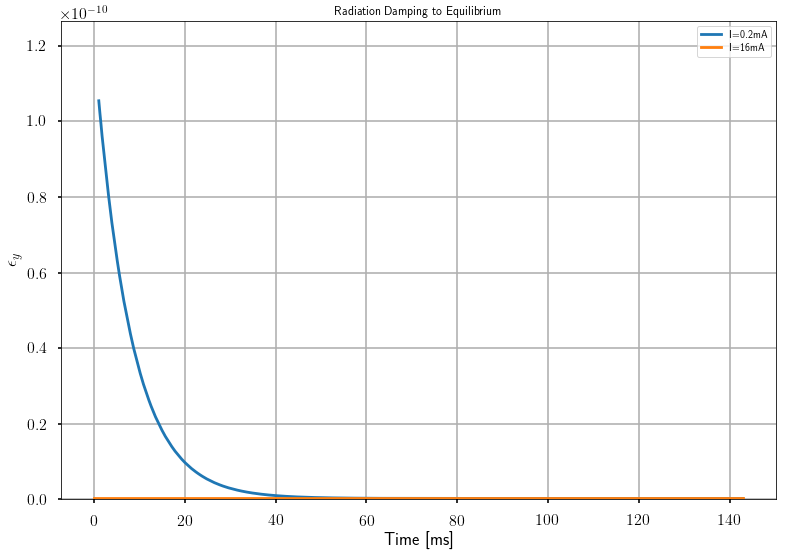

In [1329]:
plotEmit(n=1,col='ey',nmean=10,timeratio=300, legendlabels=['I=0.2mA','I=16mA','Rad Equil'],save=False, savefilename='/home/tmerten/LATEX/Presentations/IPAC18/RAD_ey')


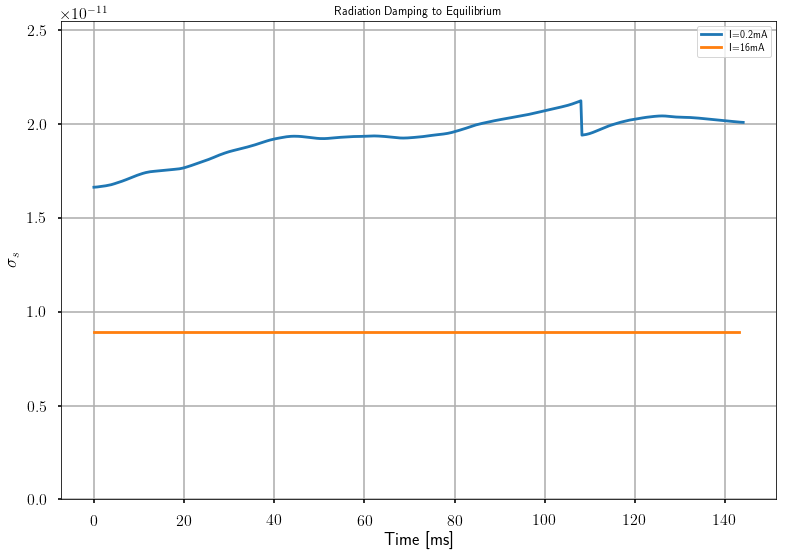

In [1330]:
plotEmit(n=1,col='sigs',nmean=1,timeratio=300, legendlabels=['I=0.2mA','I=16mA','Rad Equil'],save=False, savefilename='/home/tmerten/LATEX/Presentations/IPAC18/RAD_sigs')

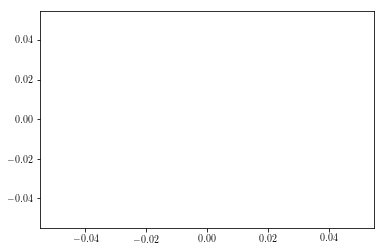

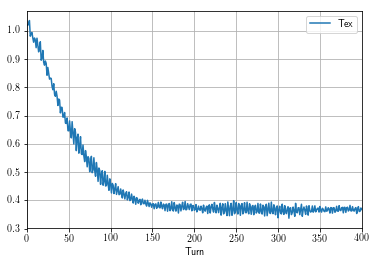

In [1310]:
plt.plot()
fibs[0].plot(x='Turn',y='Tex')
plt.grid()
plt.show()

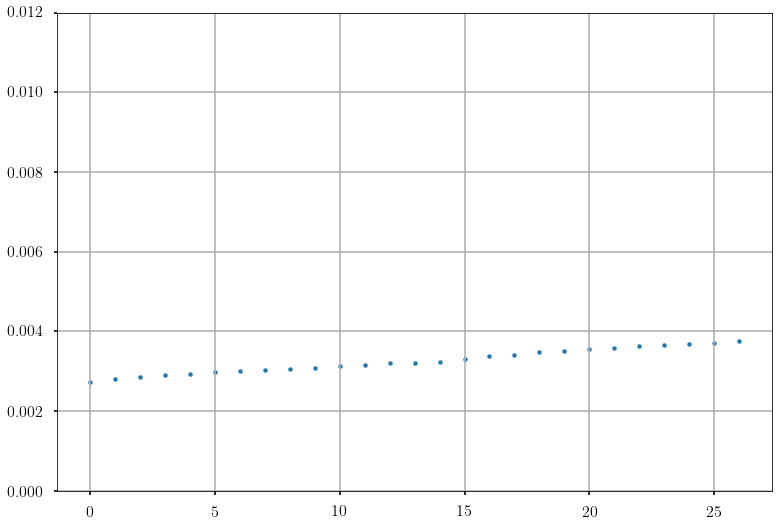

In [988]:
exx ,eyy ,sigss = extractEqui(nmean=10)
with plt.style.context(['seaborn-poster']):
#     plt.scatter(range(len(exx)),np.sqrt(np.array(exx)*betx),s=10)
    plt.scatter(range(len(sigss)),np.array(sigss)*const.c,s=15)
#     plt.scatter(range(9),np.array([np.sqrt(betx * i) for i in np.arange(1e-9,10e-9,1e-9)]),s=5)
    plt.ylim(0,1.2e-2)
    plt.grid()
    plt.show()

In [989]:
1e10/(2**3 * np.pi**(3/2.) * np.sqrt(7e-9*2*120e-12*10*3326*0.005))

13430260560375996.0

In [995]:
bmax = 13430260560375996**(-1/3)
bmin = np.sqrt(1/(np.pi *13430260560375996 * np.sqrt(120e-12*10) *0.003 ))

In [996]:
bmax ,bmin

(4.206993624214667e-06, 1.5101737099733201e-05)

In [997]:
np.log(bmax/bmin)

-1.2780614878327761

In [1058]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16,16))

for f in fibs:
    f.rolling(10).mean().dropna().plot(x='Turn',y='Tex',ax=axes[0,0])
    f.rolling(10).mean().dropna().plot(x='Turn',y='Tey',ax=axes[0,1])
    f.plot(x='Turn',y='Tp',ax=axes[1,0])
    
t= f.tail(1)['Turn'].values[0]
axes[0,0].plot(range(0,t,t-1), [0.00795572]*2)
axes[0,1].plot(range(0,t,t-1), [0.0078924]*2)
axes[1,0].plot(range(0,t,t-1), [0.00393056]*2)

axes[0,0].grid()
axes[0,0].set_xlabel('Sim Turns')
axes[1,0].grid()
axes[0,1].grid()
axes[1,1].grid()

axes[0,0].set_ylim(0,1.5)
axes[0,1].set_ylim(0,10e-2)
axes[1,0].set_ylim(0,1e-1)
plt.show()

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16,16))
for fe in femit:
    fe.rolling(10).mean().dropna().plot(x='Turn',y='ex',ax=axes[0,0])
    fe.rolling(10).mean().dropna().plot(x='Turn',y='ey',ax=axes[0,1])
    fe.rolling(50).mean().dropna().plot(x='Turn',y='sigs',ax=axes[1,0])
    fe.rolling(10).mean().dropna().plot(x='Turn',y='sige',ax=axes[1,1])

t= fe.tail(1)['Turn'].values[0]
axes[0,0].plot(range(0,t,t-1), [8.66796e-09]*2)
axes[0,1].plot(range(0,t,t-1), [2.5505e-13]*2)
axes[1,0].plot(range(0,t,t-1), [eta * const.c/ (0.0065 *omega0)*np.sqrt(1.65e-15*const.c)/const.c]*2)
axes[1,1].plot(range(0,t,t-1), [np.sqrt(1.6e-15*const.c)]*2)
               

axes[0,0].grid()
axes[1,0].grid()
axes[1,1].grid()

axes[0,0].set_ylim(0,2e-8)
axes[0,1].set_ylim(0,0.5e-11)
# axes[1,0].set_ylim(0,0.25e-13)
# axes[1,1].set_ylim(0,0.25e-5)
axes[0,1].grid()
plt.show()

# try:
#     fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,8))
#     for fintensity in [fsint[0]]:
#         fintensity.plot(x='Turn',y='Current',ax=axes[0])
#         fintensity['h'] =fintensity[fintensity['NRealLost']!=0.0]['Ttou']/3600.
#         fintensity[fintensity['NRealLost']!=0.0].rolling(4).mean().dropna().plot(x='Turn',y='h',ax=axes[1])
#         axes[0].set_ylim(0,0.017)
#         axes[0].grid()
#         axes[0].set_ylim(0,0.017)
#         axes[1].grid()
#     plt.show()
# except:
#     pass

TypeError: Empty 'DataFrame': no numeric data to plot

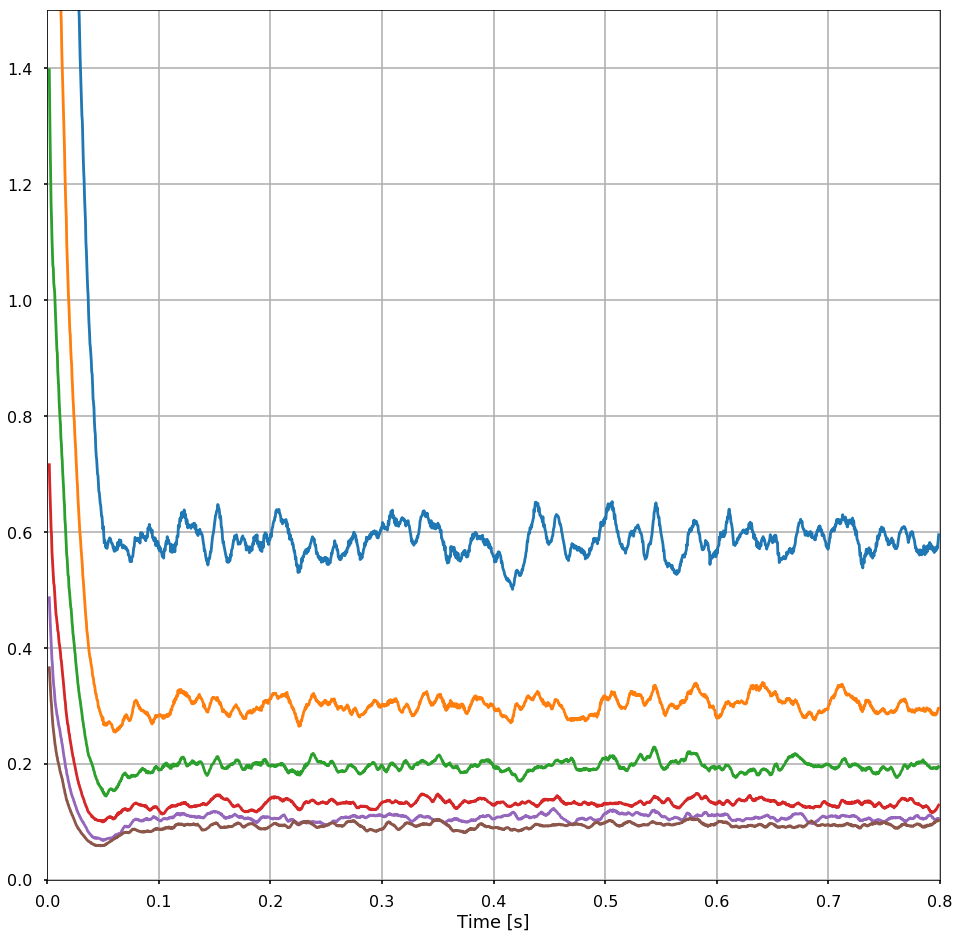

In [552]:
with plt.style.context(['seaborn-poster']):
    fig = plt.figure(figsize=(16,16))

    for f in fibs:
        plt.plot(f.rolling(10).mean().dropna()['Turn']*500*trev,f.rolling(10).mean().dropna()['Tex'])


plt.grid()
plt.xlabel('Time [s]')
plt.xlabel('Time [s]')
plt.xlim(0,.8)
plt.ylim(0,1.5)
# axes[0,1].set_ylim(0,10e-2)
# axes[1,0].set_ylim(0,1e-1)
plt.show()


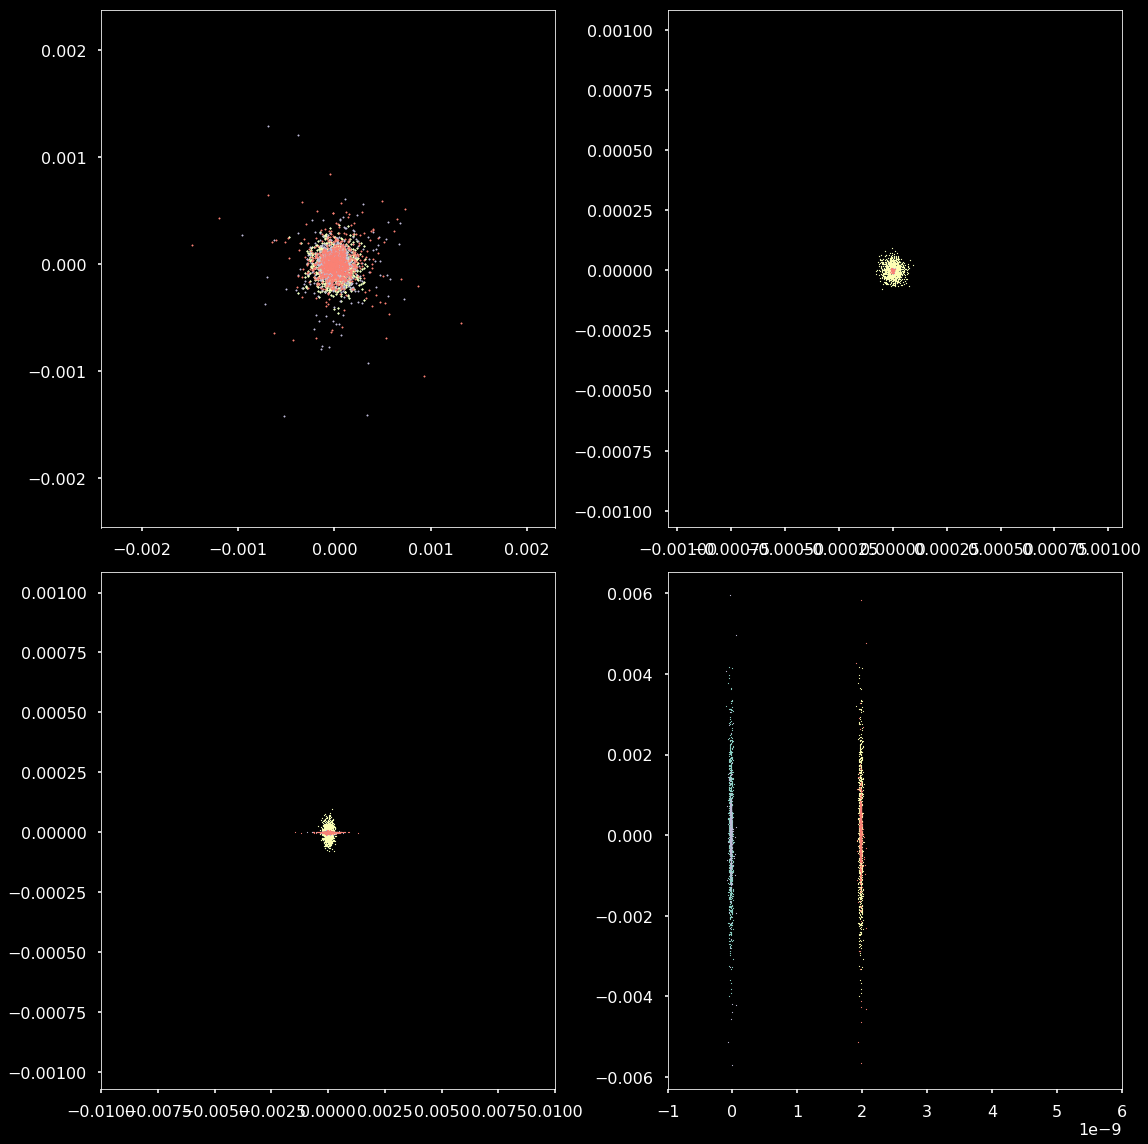

In [502]:
with plt.style.context(['seaborn-poster','dark_background']):
    fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(16,16))
    
    for i in [0,filelimit-1]:
        for dfs in [dfs1,dfs2]:
            df = dfs[i]

            axes[0,0].scatter(df[0],df[1],s=2)
            axes[0,1].scatter(df[2],df[3],s=.5)
            axes[1,0].scatter(df[0],df[2],s=.5)
            axes[1,1].scatter(df[4],df[5],s=.5)

    axes[1,1].set_xlim(-1e-9,6e-9)
    axes[1,0].set_xlim(-0.01,0.01)
    plt.tight_layout()
    
    plt.show()

In [570]:
import numpy as np
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
import matplotlib.animation as manimation

h = 400
def hamil(p,d):
    return .5 * (2*np.pi*1.25e6 * eta * h) * d**2 - (2*np.pi*1.25e6) * 1.4e6 / (2 * np.pi * 1.7e9 ) * (np.cos(p) - np.cos(phis) + (p-phis)*np.sin(phis))


FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title='Movie Test', artist='Matplotlib',
                comment='Movie support!')
writer = FFMpegWriter(fps=15, metadata=metadata)
# with plt.style.context(['seaborn-poster','dark_background']):

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (16,8))

# intialize two line objects (one in each axes)
line11, = ax1.plot([], [], '.' )
line12, = ax1.plot([], [], '.' )
line21, = ax2.plot([], [], '.' )
line22, = ax2.plot([], [], '.' ,alpha=0.2)
line = [line11, line12, line21, line22]

# fig = plt.figure()
# l, = plt.plot([], [], '.')

xi = np.linspace((phis-1.25*np.pi)/(400*2*np.pi*1.25e6), (phis+1.25*np.pi)/(400*2*np.pi*1.25e6), 200)
yi = np.linspace(-0.05,0.05, 200)
Theta, Theta_dot = np.meshgrid(xi, yi)
H = hamil(Theta*(400*2*np.pi*1.25e6), Theta_dot)
z = hamil(xi,yi)
ax1.set_xlim(-1.5e-9,1.5e-9)
ax1.set_ylim(-0.04,0.04)
rect = ax1.contour(xi, yi, H,15);
ax2.set_xlim(-0.001,0.001)
ax2.set_ylim(-0.001,0.001)
ax1.grid()
ax2.grid()

x0, y0 = 0, 0
with writer.saving(fig, "ibs.mp4", 400):
    for i in range(0,filelimit,1):
        x0 = dfs1[i][4]
        y0 = dfs1[i][5]
        rect
#         line[0].set_data(x0, y0)
#         line[0].set_markersize(2.5)
        line[0].set_data(dfs2[i][4]-2e-9, dfs2[i][5])
        line[0].set_markersize(2.5)
#         line[2].set_data(dfs1[i][0], dfs1[i][2])
#         line[2].set_markersize(2)
        line[2].set_data(dfs2[i][0], dfs2[i][2])
        line[2].set_markersize(2)
        writer.grab_frame()
        

/home/tmerten/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


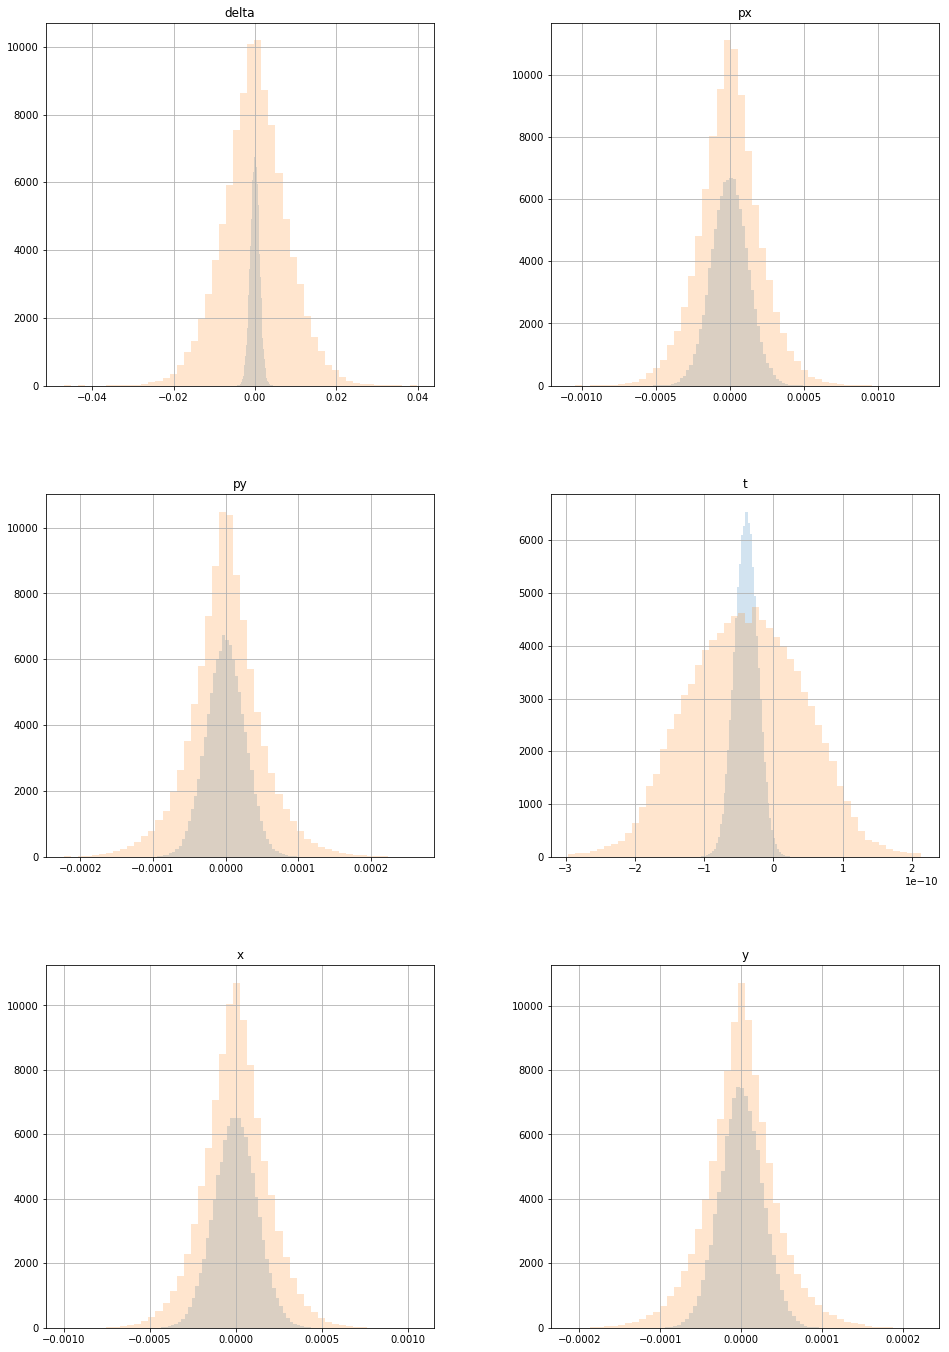

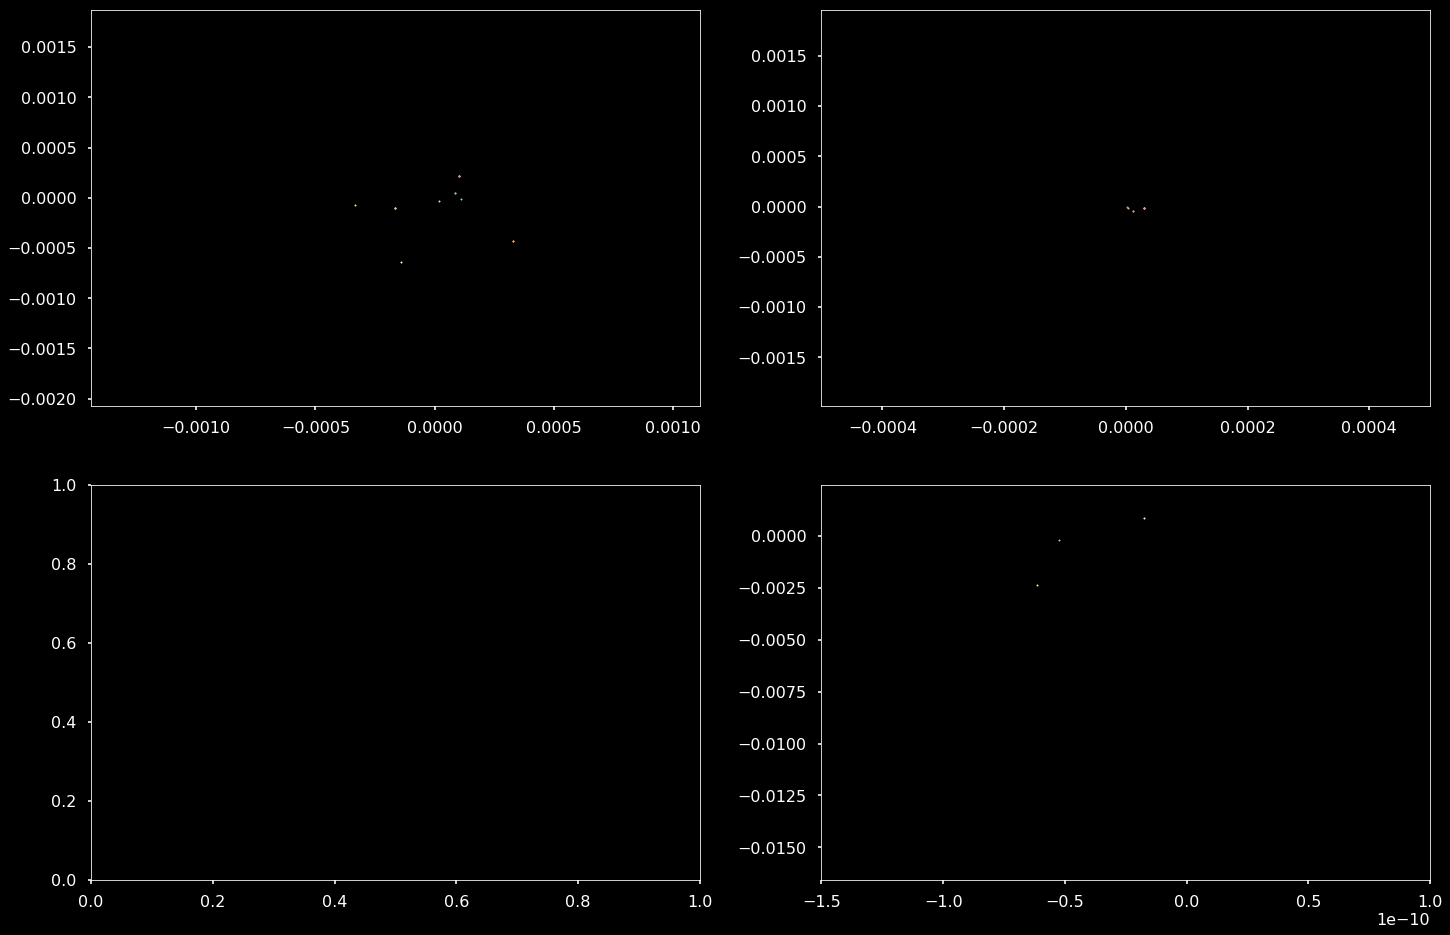

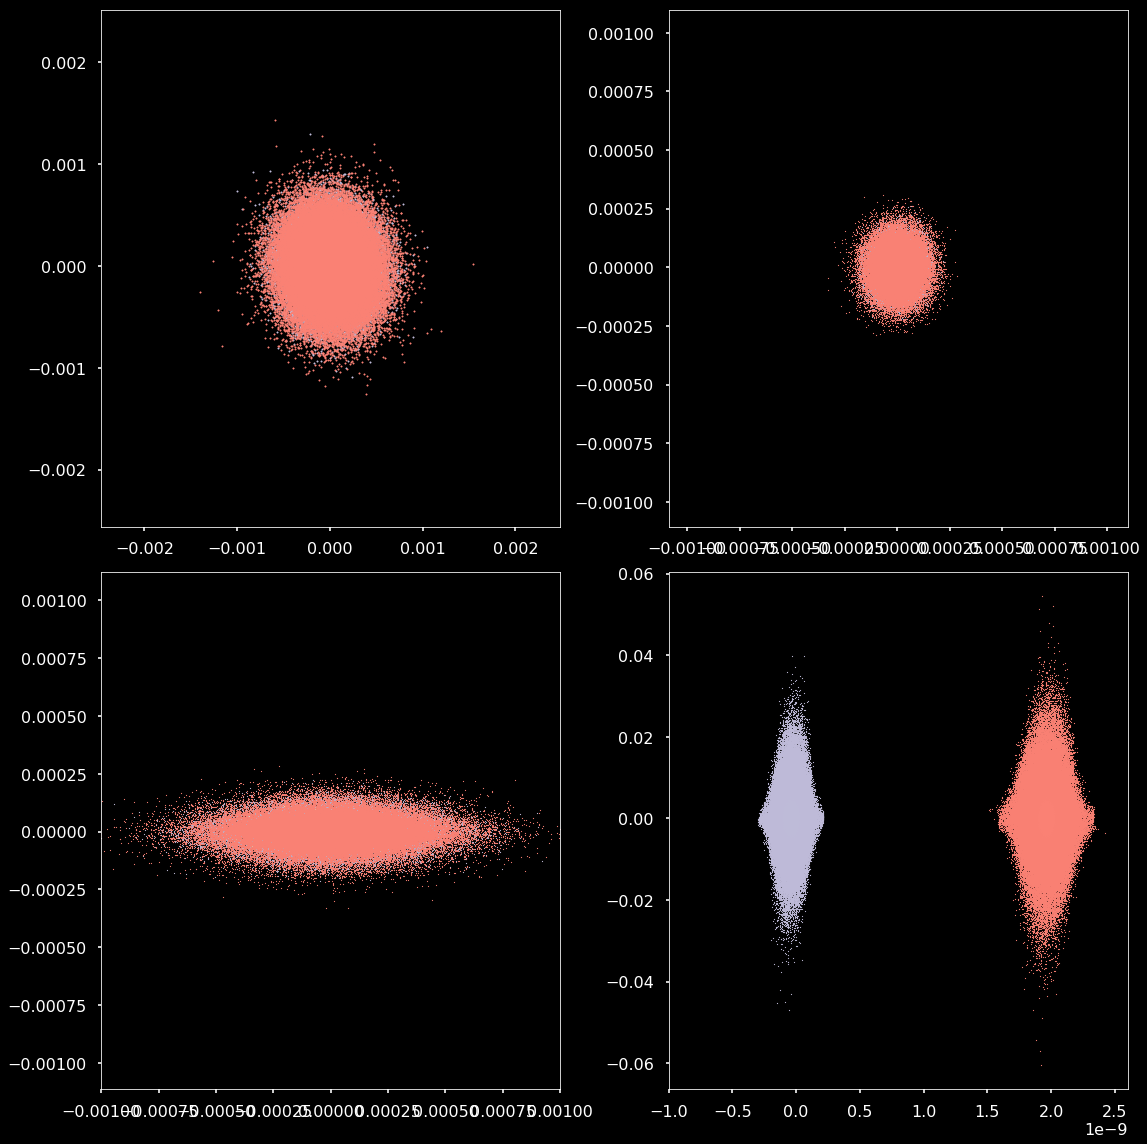

In [28]:
filelimit = 10
day = '14'

bucket0files = glob.glob('Distribution_bucket_0_' + day +'*')
bucket1files = glob.glob('Distribution_bucket_1_' + day +'*')
bucket2files = glob.glob('Distribution_bucket_2_' + day +'*')
bucket3files = glob.glob('Distribution_bucket_3_' + day +'*')

bucket0files.sort()
bucket1files.sort()
bucket2files.sort()
bucket3files.sort()

dfs1 = [pd.read_csv(file, delim_whitespace=True, header=None) for file in bucket0files[:filelimit]]
dfs2 = [pd.read_csv(file, delim_whitespace=True, header=None) for file in bucket1files[:filelimit]]
dfs3 = [pd.read_csv(file, delim_whitespace=True, header=None) for file in bucket2files[:filelimit]]
dfs4 = [pd.read_csv(file, delim_whitespace=True, header=None) for file in bucket2files[:filelimit]]

ax=dfs1[0].rename(columns={0: "x" , 1: "px", 2: "y", 3: "py", 4: "t", 5: "delta"}).hist(bins=50,alpha=0.2, figsize=(16,24))
dfs1[filelimit-1].rename(columns={0: "x" , 1: "px", 2: "y", 3: "py", 4: "t", 5: "delta"}).hist(bins=50,alpha=0.2,ax=ax)
plt.show()

with plt.style.context(['seaborn-poster','dark_background']):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(24,16))
    for i in range(0,filelimit,5):
        for dfs in [dfs1,dfs2,dfs3,dfs4]:
            df = dfs[i]
            axes[0,0].scatter(df.iloc[0][0],df.iloc[0][1],s=2)
            axes[0,0].scatter(df.iloc[9][0],df.iloc[9][1],s=2)
            axes[0,1].scatter(df.iloc[0][2],df.iloc[0][3],s=2)
            axes[1,1].scatter(df.iloc[0][4],df.iloc[0][5],s=2)
#             plt.scatter(df.iloc[10][0],df.iloc[10][1],s=1)
            axes[1,1].scatter(df.iloc[9][4],df.iloc[9][5],s=2)
#             axes[1,1].scatter(df.iloc[59][4],df.iloc[9][5],s=1)
#             axes[1,1].scatter(df.iloc[59][4],df.iloc[59][5],s=1)
#             plt.scatter(df.iloc[10][0],df.iloc[10][1],s=1)
#             plt.scatter(df.iloc[100][0],df.iloc[100][1],s=1)
#     axes[0,0].set_xlim(-0.0005,0.0005)
    axes[0,1].set_xlim(-0.0005,0.0005)
    axes[1,1].set_xlim(-1.5e-10,1e-10)
#     plt.ylim(-0.007,0.007)
plt.show()

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16,16))
for femit in [femit1, femit2,femit3,femit4,femit5,femit6]:
    femit.rolling(10).mean().dropna().plot(x='Turn',y='ex',ax=axes[0,0])
    femit.rolling(10).mean().dropna().plot(x='Turn',y='ey',ax=axes[0,1])
    femit.rolling(10).mean().dropna().plot(x='Turn',y='sigs',ax=axes[1,0])
    femit.rolling(10).mean().dropna().plot(x='Turn',y='sige',ax=axes[1,1])
axes[0,0].set_ylim(0,.5e-7)
axes[0,0].grid()

axes[0,1].set_ylim(0,2e-8)
axes[0,1].grid()
plt.show()

In [25]:
fintensity1 = pd.read_csv('STE_Intensity_0_'+day+'_02_2018.dat', delim_whitespace=True)
fibs1 = pd.read_csv('STE_IBS_LifeTimes_0_'+day+'_02_2018.dat', delim_whitespace=True)
femit1 = pd.read_csv('STE_Emittances_0_'+day+'_02_2018.dat', delim_whitespace=True)
fintensity2 = pd.read_csv('STE_Intensity_1_'+day+'_02_2018.dat', delim_whitespace=True)
fibs2 = pd.read_csv('STE_IBS_LifeTimes_1_'+day+'_02_2018.dat', delim_whitespace=True)
femit2 = pd.read_csv('STE_Emittances_1_'+day+'_02_2018.dat', delim_whitespace=True)
fintensity3 = pd.read_csv('STE_Intensity_2_'+day+'_02_2018.dat', delim_whitespace=True)
fibs3 = pd.read_csv('STE_IBS_LifeTimes_2_'+day+'_02_2018.dat', delim_whitespace=True)
femit3 = pd.read_csv('STE_Emittances_2_'+day+'_02_2018.dat', delim_whitespace=True)
fintensity4 = pd.read_csv('STE_Intensity_3_'+day+'_02_2018.dat', delim_whitespace=True)
fibs4 = pd.read_csv('STE_IBS_LifeTimes_3_'+day+'_02_2018.dat', delim_whitespace=True)
femit4 = pd.read_csv('STE_Emittances_3_'+day+'_02_2018.dat', delim_whitespace=True)
fintensity5 = pd.read_csv('STE_Intensity_4_'+day+'_02_2018.dat', delim_whitespace=True)
fibs5 = pd.read_csv('STE_IBS_LifeTimes_4_'+day+'_02_2018.dat', delim_whitespace=True)
femit5 = pd.read_csv('STE_Emittances_4_'+day+'_02_2018.dat', delim_whitespace=True)
fintensity6 = pd.read_csv('STE_Intensity_5_'+day+'_02_2018.dat', delim_whitespace=True)
fibs6 = pd.read_csv('STE_IBS_LifeTimes_5_'+day+'_02_2018.dat', delim_whitespace=True)
femit6 = pd.read_csv('STE_Emittances_5_'+day+'_02_2018.dat', delim_whitespace=True)
fintensity7 = pd.read_csv('STE_Intensity_6_'+day+'_02_2018.dat', delim_whitespace=True)
fibs7 = pd.read_csv('STE_IBS_LifeTimes_6_'+day+'_02_2018.dat', delim_whitespace=True)
femit7 = pd.read_csv('STE_Emittances_6_'+day+'_02_2018.dat', delim_whitespace=True)
fintensity8 = pd.read_csv('STE_Intensity_7_'+day+'_02_2018.dat', delim_whitespace=True)
fibs8 = pd.read_csv('STE_IBS_LifeTimes_7_'+day+'_02_2018.dat', delim_whitespace=True)
femit8 = pd.read_csv('STE_Emittances_7_'+day+'_02_2018.dat', delim_whitespace=True)

In [39]:
fibs1.head()

,Turn,Tex,Tey,Tp
0,0,1.631460e-07,0.000005,1.426580e-08
1,1,1.631460e-07,0.000005,1.426580e-08
2,2,4.233450e-07,0.000009,2.145250e-06
3,3,3.928150e-06,0.000128,9.251710e-06
4,4,4.887210e-06,0.000054,8.267780e-06


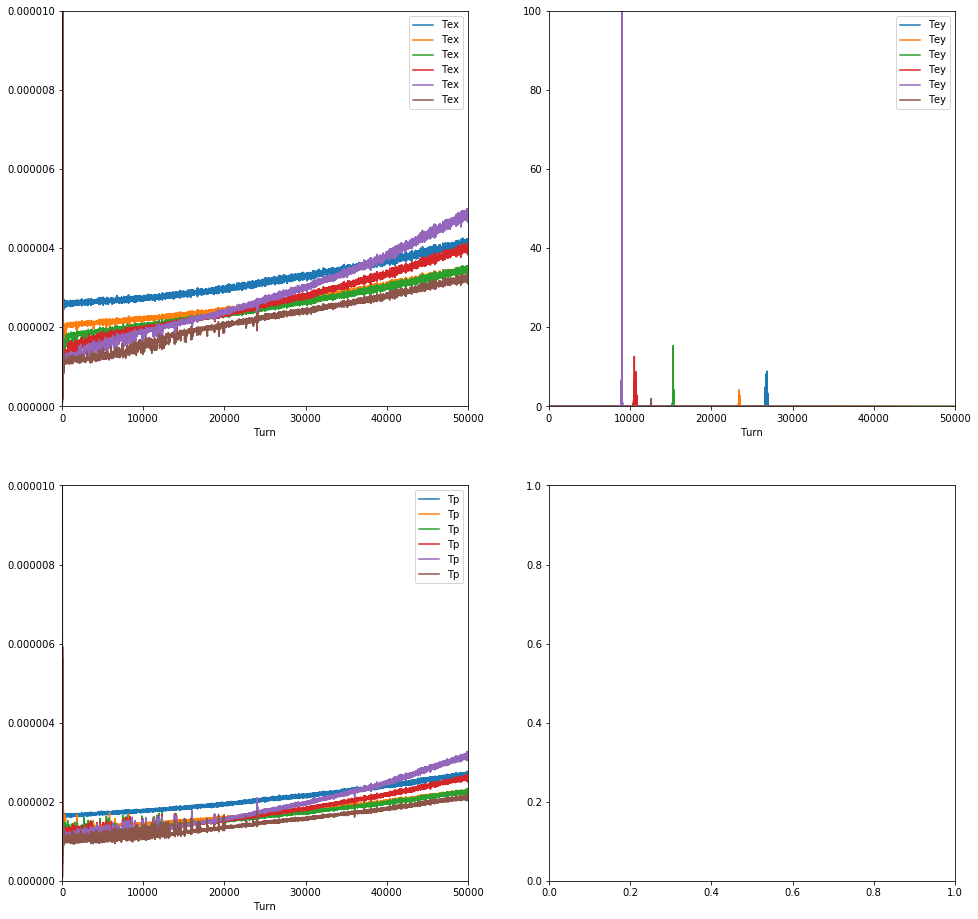

In [38]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16,16))
for fibs in [fibs1, fibs2,fibs3,fibs4,fibs5,fibs6]:
    fibs.rolling(1).mean().dropna().plot(x='Turn',y='Tex',ax=axes[0,0])
    fibs.rolling(1).mean().dropna().plot(x='Turn',y='Tey',ax=axes[0,1])
    fibs.plot(x='Turn',y='Tp',ax=axes[1,0])
# femit.plot(x='Turn',y='sige',ax=axes[1,1])
axes[0,0].set_ylim(0,1e-5)
axes[0,1].set_ylim(-1e-2,1e3)
axes[1,0].set_ylim(0,1e-5)
plt.show()

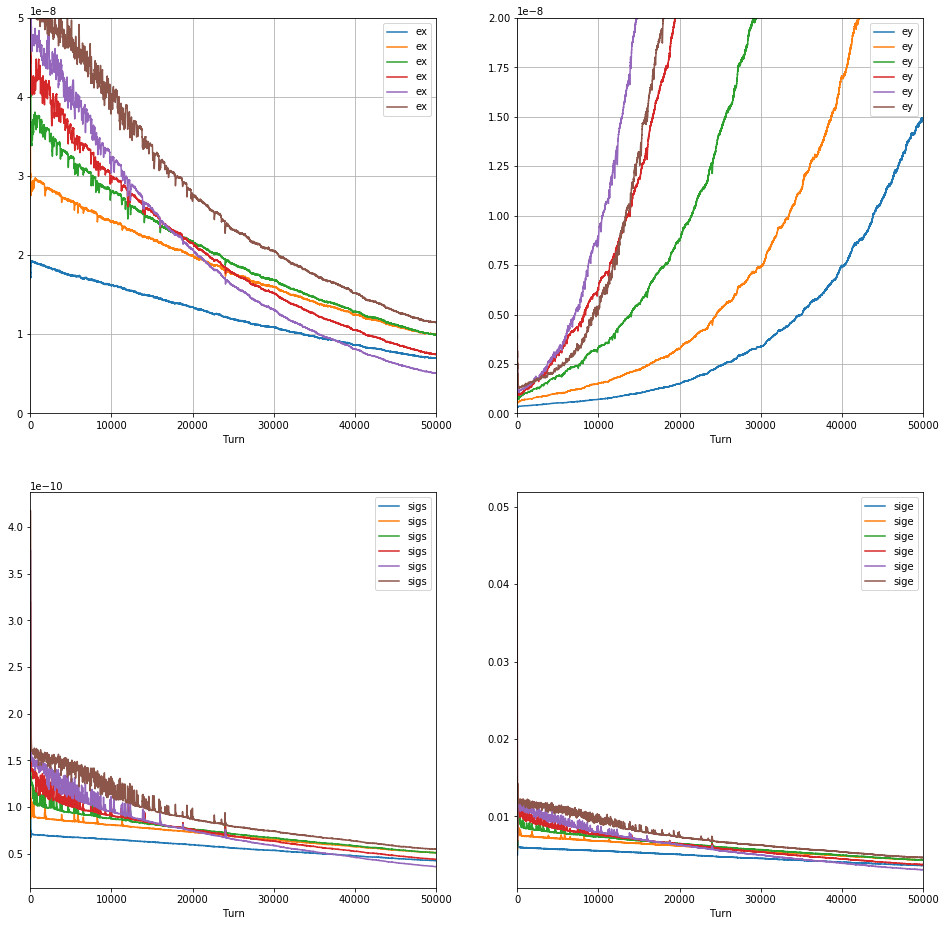

In [34]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16,16))
for femit in [femit1, femit2,femit3,femit4,femit5,femit6]:
    femit.rolling(10).mean().dropna().plot(x='Turn',y='ex',ax=axes[0,0])
    femit.rolling(10).mean().dropna().plot(x='Turn',y='ey',ax=axes[0,1])
    femit.rolling(10).mean().dropna().plot(x='Turn',y='sigs',ax=axes[1,0])
    femit.rolling(10).mean().dropna().plot(x='Turn',y='sige',ax=axes[1,1])
axes[0,0].set_ylim(0,.5e-7)
axes[0,0].grid()

axes[0,1].set_ylim(0,2e-8)
axes[0,1].grid()
plt.show()

In [432]:
df = fintensity[['Turn','Ttou']]
df = df[~(df == 0.0).any(axis=1)]
df['diff'] = df['Turn'].diff(1)

In [433]:
df['tau'] = - df['diff'] * df['Ttou']

In [439]:
df = fintensity[['Turn','Ttou']]
df = df[~(df == 0.0).any(axis=1)]
df

,Turn,Ttou
125,125,8.00582


In [462]:
8e10*144*1/(1.25e6)/8e5

11.52

In [513]:
df = fintensity4[fintensity4['NRealLost']!=0.0].copy()
df.rolling(5).mean()

,Turn,NMacro,Current,NReal,NRealLost,Ttou,h
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,7.0,99889.4,0.015992,7.991152e+10,59680000.0,16.607232,0.004613
10,8.0,99740.0,0.015969,7.979200e+10,119520000.0,0.604100,0.000168
11,9.0,99491.4,0.015929,7.959312e+10,198880000.0,0.210120,0.000058
12,10.0,99126.4,0.015870,7.930112e+10,292000000.0,0.062886,0.000017
13,11.0,98644.8,0.015793,7.891584e+10,385280000.0,0.038318,0.000011
14,12.0,98055.2,0.015699,7.844416e+10,471680000.0,0.028631,0.000008


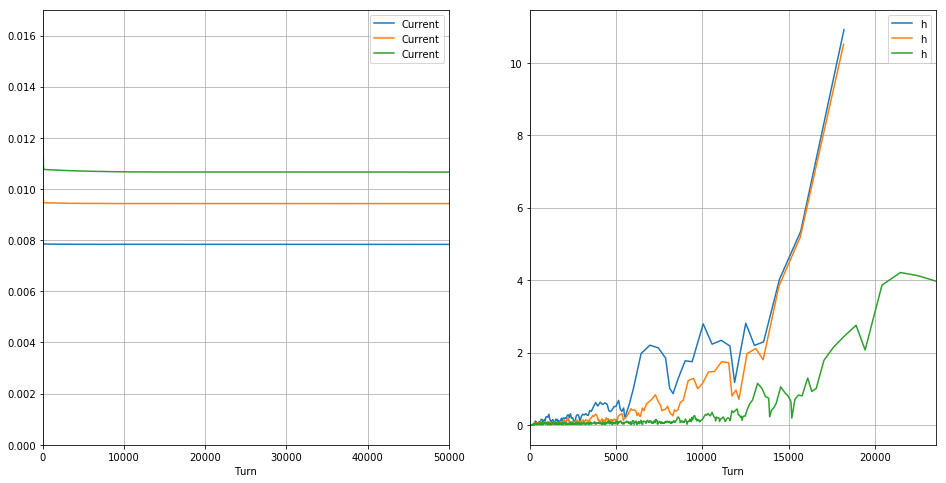

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,8))
for fintensity in [fintensity4,fintensity5, fintensity6,fintensity5, fintensity6]:
    fintensity.plot(x='Turn',y='Current',ax=axes[0])
    fintensity['h'] =fintensity[fintensity['NRealLost']!=0.0]['Ttou']/3600.
    fintensity[fintensity['NRealLost']!=0.0].rolling(4).mean().dropna().plot(x='Turn',y='h',ax=axes[1])
    axes[0].set_ylim(0,0.017)
    axes[0].grid()
    axes[0].set_ylim(0,0.017)
    axes[1].grid()
plt.show()

In [447]:
fintensity

,Turn,NMacro,Current,NReal,NRealLost,Ttou
0,0,100000,0.004003,2.000000e+10,0,0
1,1,100000,0.004003,2.000000e+10,0,0
2,2,100000,0.004003,2.000000e+10,0,0
3,3,100000,0.004003,2.000000e+10,0,0
4,4,100000,0.004003,2.000000e+10,0,0
5,5,100000,0.004003,2.000000e+10,0,0
6,6,100000,0.004003,2.000000e+10,0,0
7,7,100000,0.004003,2.000000e+10,0,0
8,8,100000,0.004003,2.000000e+10,0,0
9,9,100000,0.004003,2.000000e+10,0,0


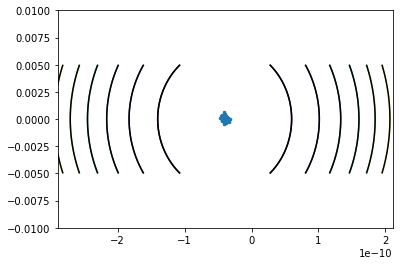

In [161]:
from matplotlib.mlab import griddata

xi = np.linspace((phis-np.pi/4)/(400*2*np.pi*1.25e6), (phis+np.pi/4)/(400*2*np.pi*1.25e6), 200)
yi = np.linspace(-0.005,0.005, 200)
Theta, Theta_dot = np.meshgrid(xi, yi)
H = hamil(Theta*(400*2*np.pi*1.25e6), Theta_dot)
z = hamil(xi,yi)
plt.contour(xi, yi, H, colors='k')
plt.ylim(-0.01,.01)
# plt.xlim(-0.124,0.5)
plt.show()

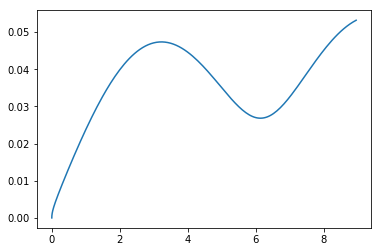

In [108]:
x = [(phis-np.pi/4)/2/np.pi/500.0e6]
y = [0]
for i in range(1,200):
    x.append(x[i-1]-dphi(h,eta,y[i-1]))
    y.append(y[i-1]+ddelta(1.4e6,1.7e9,x[i],phis))

plt.plot(x,y)
# plt.xlim(-1e-10,.5e-11)
# plt.ylim(-0.001, 0.001)
plt.show()

In [ ]:

# make up data.
random_state = np.random.RandomState(19680801)

npts = 200
x = random_state.uniform(-2, 2, npts)
y = random_state.uniform(-2, 2, npts)
z = x*np.exp(-x**2 - y**2)
# define grid.
xi = np.linspace(-2.1, 2.1, 100)
yi = np.linspace(-2.1, 2.1, 200)
# grid the data.
zi = griddata(x, y, z, xi, yi, interp='linear')
# contour the gridded data, plotting dots at the nonuniform data points.
CS = plt.contour(xi, yi, zi, 15, linewidths=0.5, colors='k')
CS = plt.contourf(xi, yi, zi, 15,
                  vmax=abs(zi).max(), vmin=-abs(zi).max())
plt.colorbar()  # draw colorbar
# plot data points.
plt.scatter(x, y, marker='o', s=5, zorder=10)
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.title('griddata test (%d points)' % npts)
plt.show()

In [196]:
import numpy as np
import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
import matplotlib.animation as manimation

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title='Movie Test', artist='Matplotlib',
                comment='Movie support!')
writer = FFMpegWriter(fps=15, metadata=metadata)
# with plt.style.context(['seaborn-poster','dark_background']):

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (16,8))

# intialize two line objects (one in each axes)
line1, = ax1.plot([], [], '.' )
line2, = ax2.plot([], [], '.' )
line = [line1, line2]

# fig = plt.figure()
# l, = plt.plot([], [], '.')

xi = np.linspace((phis-np.pi)/(400*2*np.pi*1.25e6), (phis+np.pi)/(400*2*np.pi*1.25e6), 200)
yi = np.linspace(-0.05,0.05, 200)
Theta, Theta_dot = np.meshgrid(xi, yi)
H = hamil(Theta*(400*2*np.pi*1.25e6), Theta_dot)
z = hamil(xi,yi)
ax1.set_xlim(-1e-9,1e-9)
ax1.set_ylim(-0.04,0.04)
rect = ax1.contour(xi, yi, H,10)
ax2.set_xlim(-0.001,0.001)
ax2.set_ylim(-0.001,0.001)
ax1.grid()
ax2.grid()

x0, y0 = 0, 0
with writer.saving(fig, "combined.mp4", 200):
    for i in range(0,2000,10):
        x0 = dfs1[i][4]
        y0 = dfs1[i][5]
        rect
        line[0].set_data(x0, y0)
        line[0].set_markersize(1)
        line[1].set_data(dfs1[i][0], dfs1[i][2])
        line[1].set_markersize(2)
        writer.grab_frame()
        

/home/tmerten/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [173]:
FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title='Movie Test', artist='Matplotlib',
                comment='Movie support!')
writer = FFMpegWriter(fps=15, metadata=metadata)
# with plt.style.context(['seaborn-poster','dark_background']):
fig = plt.figure()
l, = plt.plot([], [], '.')

plt.xlim(-0.001,0.001)
plt.ylim(-0.001,0.001)
x0, y0 = 0, 0
with writer.saving(fig, "transverse.mp4", 100):
    for i in range(0,1000,10):
        x0 = dfs1[i][0]
        y0 = dfs1[i][2]
        rect
        l.set_data(x0, y0)
        l.set_markersize(1)
        writer.grab_frame()
        

In [361]:
with plt.style.context(['seaborn-poster','dark_background']):
    fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(16,16))
    
    for i in [0,20,2]:
        for dfs in [dfs1]:
            df = dfs[i]

            axes[0,0].scatter(df[0],df[1],s=2)
            axes[0,1].scatter(df[2],df[3],s=.5)
            axes[1,0].scatter(df[0],df[2],s=.5)
            axes[1,1].scatter(df[4],df[5],s=.5)

    axes[1,1].set_xlim(-1e-10,.5e-11)
    axes[1,0].set_xlim(-0.01,0.001)
    plt.tight_layout()
    
    plt.show()

IndexError: list index out of range

In [2001]:
filelimit = 2000

In [2021]:
bucket0files = glob.glob('Distribution_bucket_0_08*')
bucket1files = glob.glob('Distribution_bucket_1_08*')
bucket2files = glob.glob('Distribution_bucket_2_08*')
bucket0files.sort()
bucket1files.sort()
bucket2files.sort()

In [2022]:
dfs1 = [pd.read_csv(file, delim_whitespace=True, header=None) for file in bucket0files[:filelimit]]
dfs2 = [pd.read_csv(file, delim_whitespace=True, header=None) for file in bucket1files[:filelimit]]
dfs3 = [pd.read_csv(file, delim_whitespace=True, header=None) for file in bucket2files[:filelimit]]

In [2023]:
dfs1[0].mean()

0   -7.517405e-06
1    7.727522e-06
2   -2.746229e-06
3   -2.017712e-06
4   -3.912747e-11
5   -6.270651e-06
dtype: float64

In [2024]:
dfs2[0].mean()

0   -7.517405e-06
1    7.727522e-06
2   -2.746229e-06
3   -2.017712e-06
4    1.962327e-09
5   -6.270651e-06
dtype: float64

In [2025]:
dfs3[0].mean()

0   -7.517405e-06
1    7.727522e-06
2   -2.746229e-06
3   -2.017712e-06
4    3.964086e-09
5   -1.950866e-05
dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f588fe84cf8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f588fd5b128>]], dtype=object)

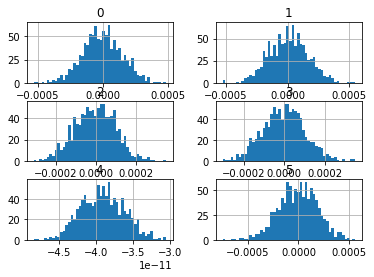

In [2026]:
dfs1[0].hist(bins=50)

In [52]:
with plt.style.context(['seaborn-poster','dark_background']):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(24,16))
    for i in range(0,filelimit,5):
        for dfs in [dfs1]:
            df = dfs[i]
            axes[0,0].scatter(df.iloc[0][0],df.iloc[0][1],s=.2)
            axes[0,0].scatter(df.iloc[9][0],df.iloc[9][1],s=.2)
            axes[0,1].scatter(df.iloc[0][2],df.iloc[0][3],s=.2)
            axes[1,1].scatter(df.iloc[0][4],df.iloc[0][5],s=5)
#             plt.scatter(df.iloc[10][0],df.iloc[10][1],s=1)
            axes[1,1].scatter(df.iloc[9][4],df.iloc[9][5],s=5)
#             axes[1,1].scatter(df.iloc[59][4],df.iloc[9][5],s=1)
#             axes[1,1].scatter(df.iloc[59][4],df.iloc[59][5],s=1)
#             plt.scatter(df.iloc[10][0],df.iloc[10][1],s=1)
#             plt.scatter(df.iloc[100][0],df.iloc[100][1],s=1)
    axes[0,0].set_xlim(-0.0005,0.0005)
    axes[0,1].set_xlim(-0.0005,0.0005)
    axes[1,1].set_xlim(-1.5e-10,1e-10)
#     plt.ylim(-0.007,0.007)


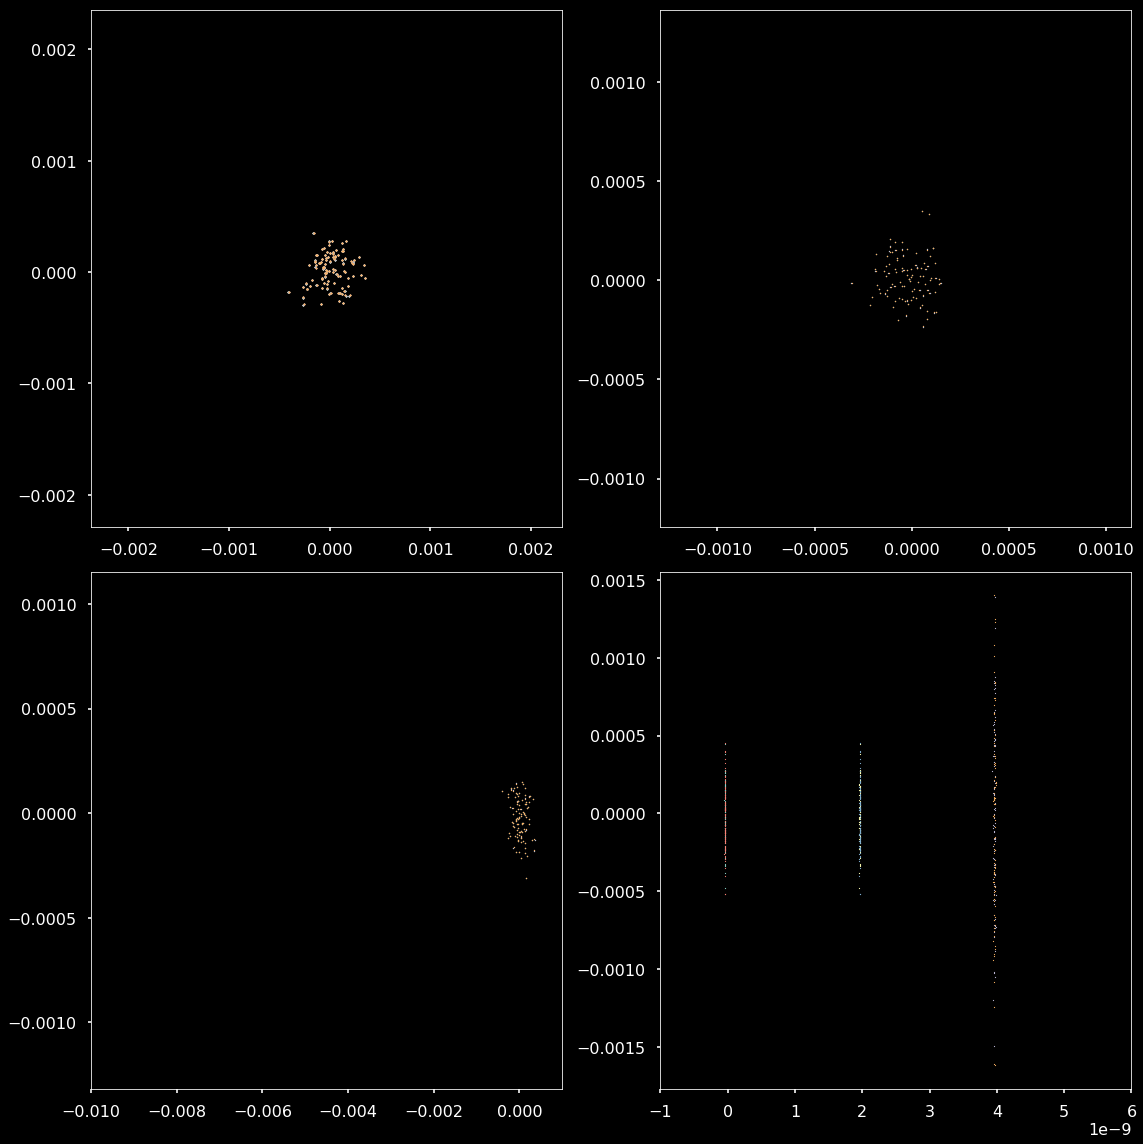

In [54]:
with plt.style.context(['seaborn-poster','dark_background']):
    fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(16,16))
    
    for i in [0,150]:
        for dfs in [dfs1,dfs2,dfs3]:
            df = dfs[i]

            axes[0,0].scatter(df[0],df[1],s=2)
            axes[0,1].scatter(df[2],df[3],s=.5)
            axes[1,0].scatter(df[0],df[2],s=.5)
            axes[1,1].scatter(df[4],df[5],s=.5)

    axes[1,1].set_xlim(-1e-9,6e-9)
    axes[1,0].set_xlim(-0.01,0.001)
    plt.tight_layout()
    
    plt.show()

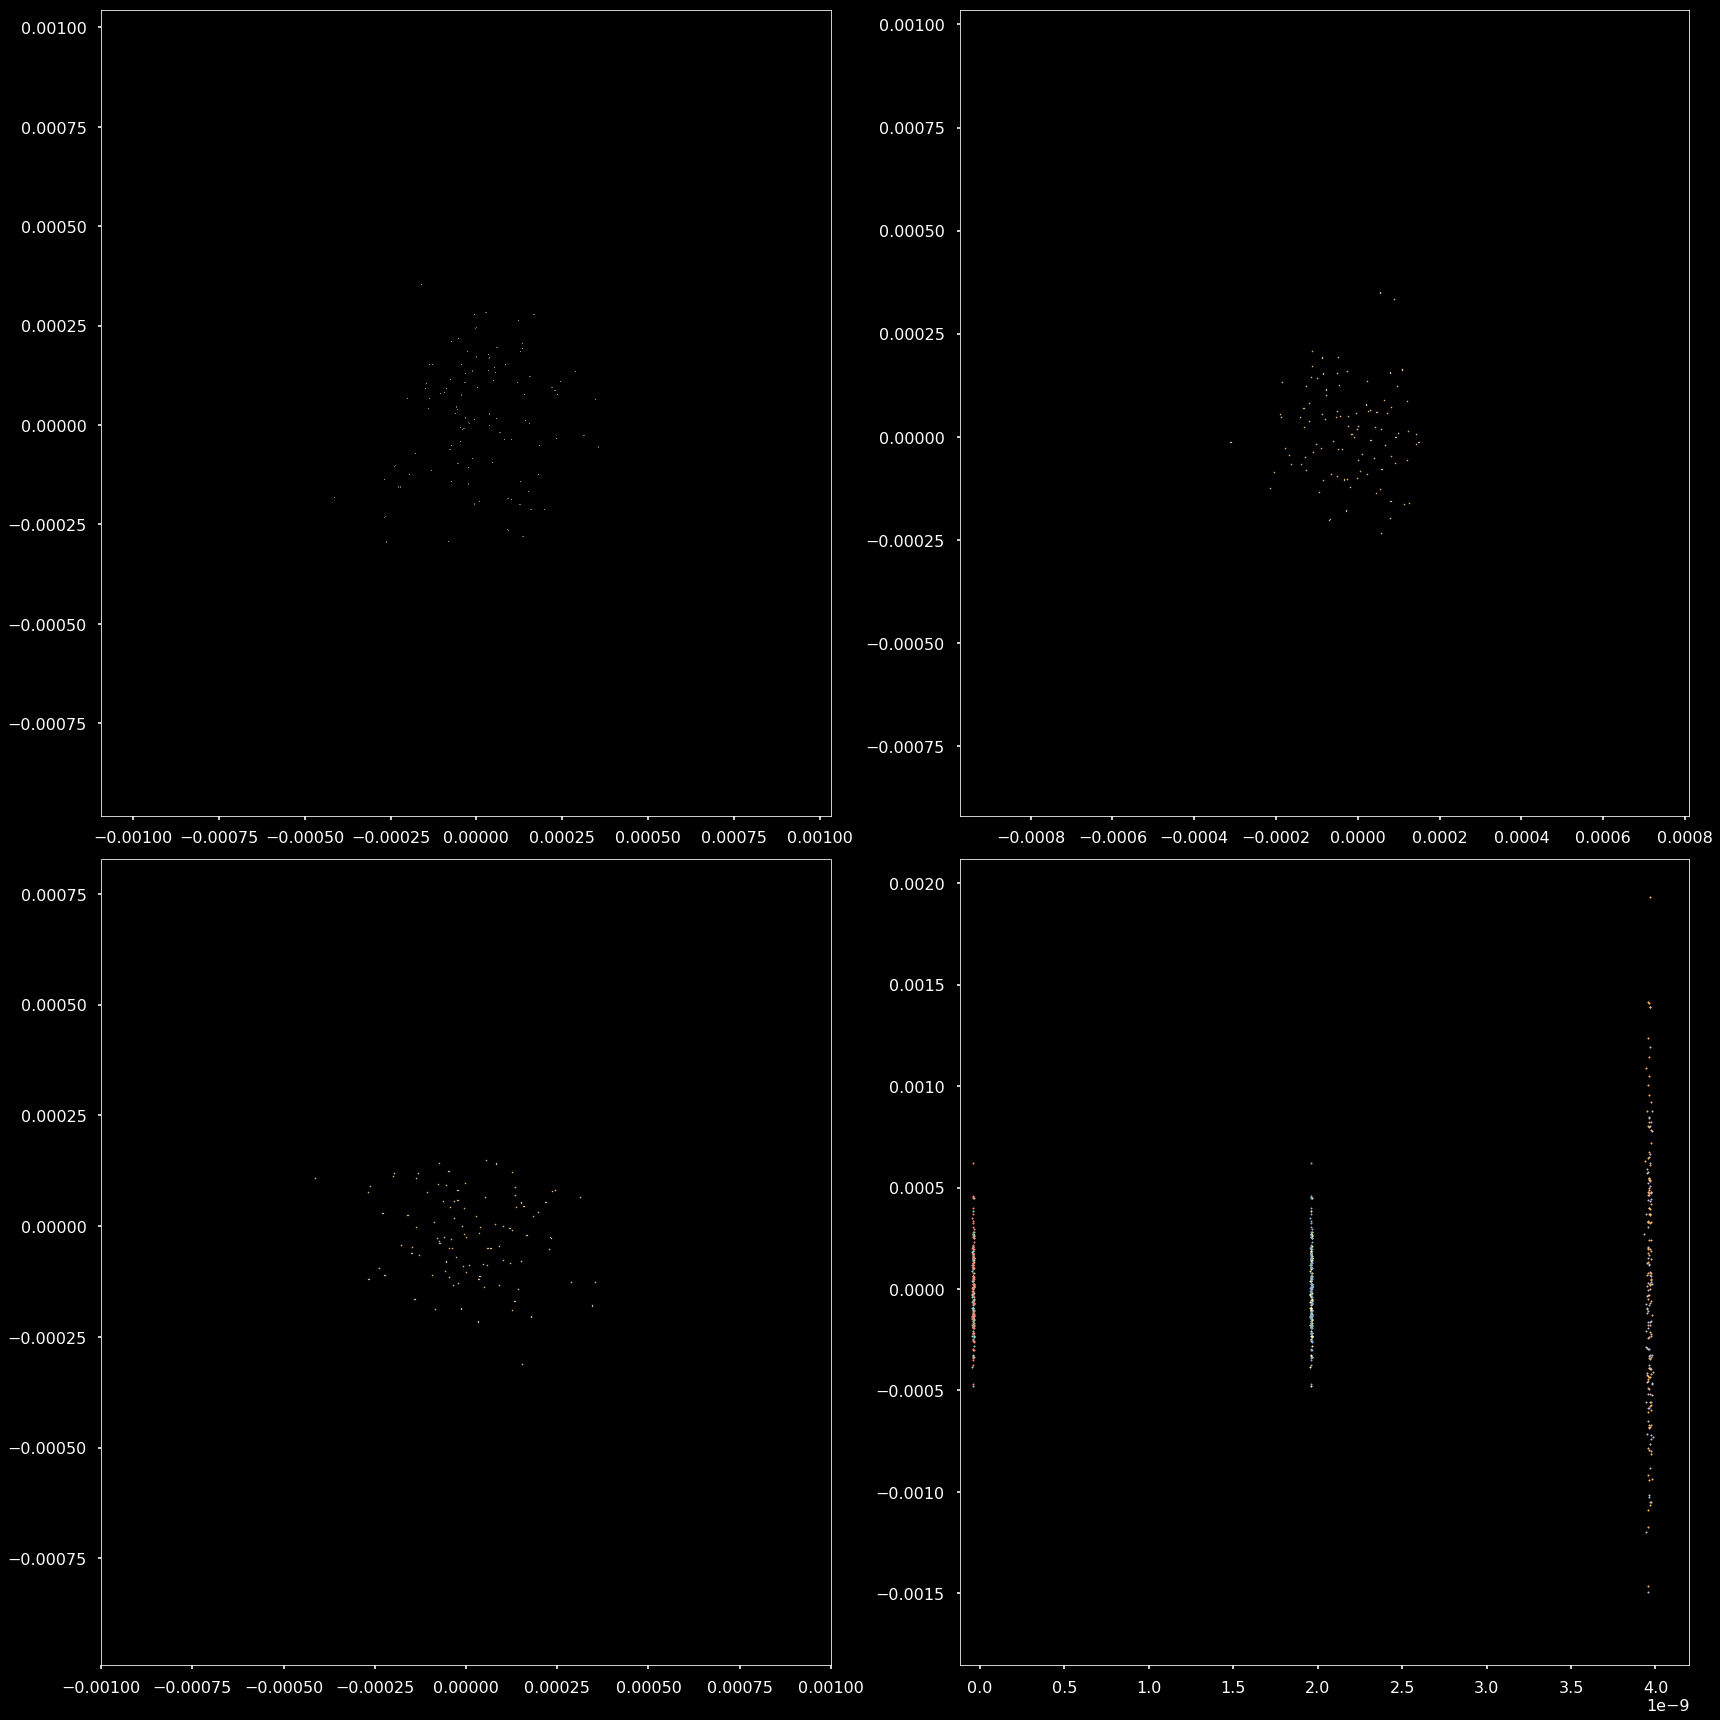

In [57]:
with plt.style.context(['seaborn-poster','dark_background']):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(24,24))
    
    for i in [0,40]:
        for dfs in [dfs1,dfs2,dfs3]:
            df = dfs[i]

            axes[0,0].scatter(df[0],df[1],s=0.5,alpha=0.2)
            axes[0,1].scatter(df[2],df[3],s=.5)
            axes[1,0].scatter(df[0],df[2],s=.5)
            axes[1,1].scatter(df[4],df[5],s=2)

    axes[1,1].set_xlim(-1.2e-10,4.2e-9)
    axes[1,0].set_xlim(-0.001,0.001)
    plt.tight_layout()
    
    plt.show()

(-5e-10, 5e-10)

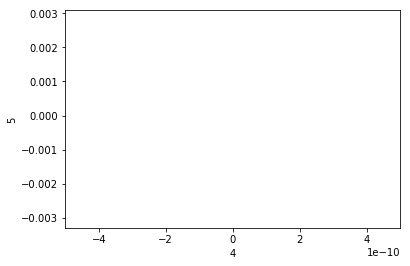

In [2031]:
dfs2[99].plot.scatter(x=4,y=5,s=1)
plt.xlim(-5e-10,5e-10)

In [2037]:
arr = {}
for i, df in enumerate(dfs1):
    arr[i]= df[5].mean()

In [2045]:
-4.000602e-11*400*1.25e6*2*np.pi

-0.12568261853136634

In [2033]:
dfs1[0].mean()

0   -7.517405e-06
1    7.727522e-06
2   -2.746229e-06
3   -2.017712e-06
4   -3.912747e-11
5   -6.270651e-06
dtype: float64

In [2044]:
dfs1[1000].mean()

0    9.985740e-06
1   -2.326254e-06
2   -3.229738e-06
3   -2.516010e-07
4   -4.000602e-11
5    4.143143e-06
dtype: float64

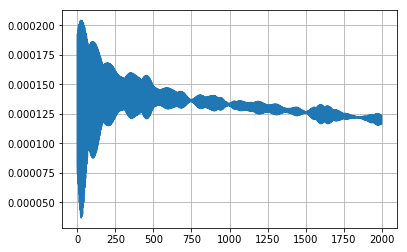

In [2035]:
plt
plt.plot(list(arr.keys()),list(arr.values()))
plt.grid()

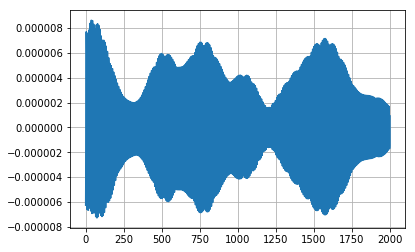

In [2038]:
plt
plt.plot(list(arr.keys()),list(arr.values()))
plt.grid()

In [1199]:
betar = np.sqrt(1-1 / 3328**2); 
trev =240.00839/ (betar * 299e8);

In [1200]:
omega0 = 2* np.pi  / trev

In [1201]:
omega0

782752770.44909

In [1205]:
0.05 *omega0/500e6

0.078275277044908997

In [2048]:
arrt = {}
for i, df in enumerate(dfs1):
    arrt[i]= df[4].std()

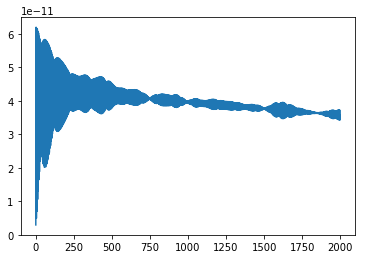

In [2051]:
plt.plot(list(arrt.keys()),[l for l in list(arrt.values())])

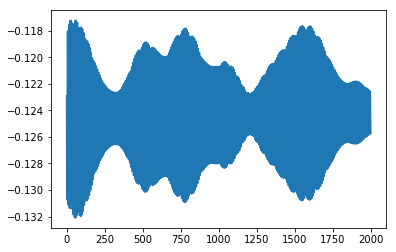

In [2047]:
plt.plot(list(arrt.keys()),[l*400* np.pi *2 *1.25e6 for l in list(arrt.values())])

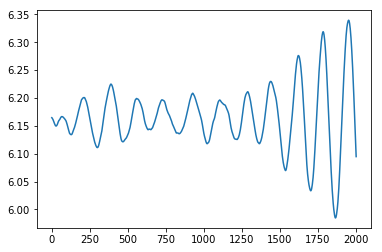

In [1194]:
plt.plot(list(arrt.keys()),[l*400* np.pi *2 *1.25e6 for l in list(arrt.values())])

In [328]:
[l*400* np.pi *2 *1.25e6 for l in list(arrt.values())][0]

-0.12418919272012546

In [ ]:
-0.1232855245471000671

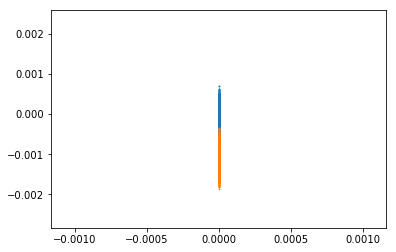

In [295]:
plt.scatter(dfs2[0][4],dfs2[0][5],s=.5)
plt.scatter(dfs2[24][4],dfs2[24][5],s=.5)

In [296]:
emitbucket0  = pd.read_csv('STE_Emittances_0_02_02_2018.dat', delim_whitespace=True)
emitbucket1  = pd.read_csv('STE_Emittances_1_02_02_2018.dat', delim_whitespace=True)

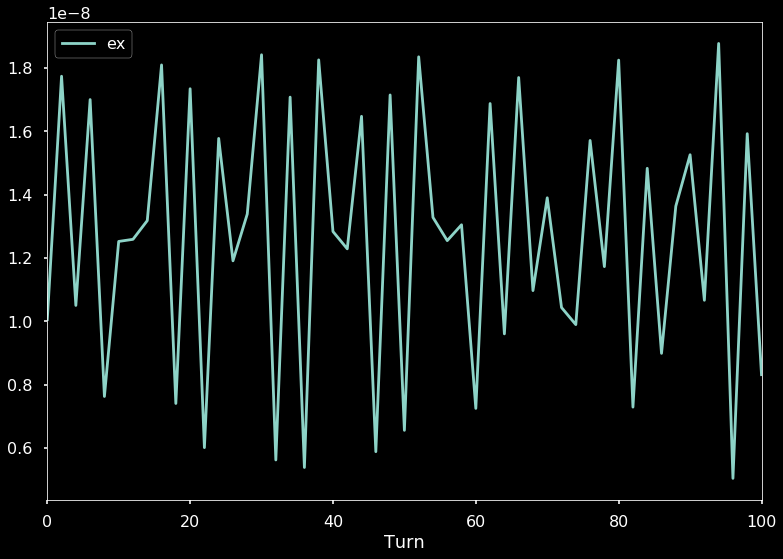

In [503]:
%matplotlib inline
with plt.style.context(['seaborn-poster','dark_background']):
    emitbucket0.plot(x='Turn',y='ex')

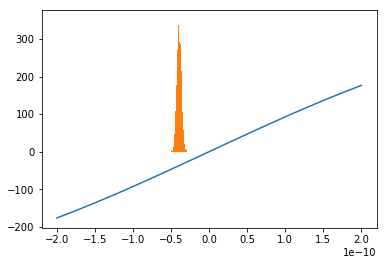

In [431]:
x = np.arange(-2e-10,2e-10,1e-11)
y = 300*np.sin(2*np.pi*1.25e6*x*400)
plt.plot(x,y)
plt.hist(dfs1[0][4], bins=100);

In [440]:
(dfs1[10][5]-dfs1[0][5]).mean()

-0.00044743390700889866

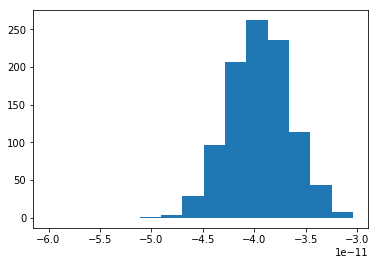

In [354]:
plt.hist(dfs1[0][4])
plt.plot(np.arange(-6e-11,-2e-11,100), [np.sin(400*1.25e6*2*np.pi * t) for t in np.arange(-6e-11,-2e-11,100)] )

In [334]:
dfs1[0].head()

,0,1,2,3,4,5
0,0.000019,-0.000420,-1.882620e-04,0.000016,-4.053630e-11,0.000296
1,-0.000207,-0.000077,-5.518720e-05,-0.000062,-4.115790e-11,-0.000220
2,-0.000243,-0.000072,-7.627910e-06,-0.000252,-3.772710e-11,0.000196
3,0.000121,-0.000204,8.211270e-07,0.000233,-4.065980e-11,-0.000199
4,0.000121,-0.000131,-4.429340e-05,0.000098,-4.021270e-11,-0.000282


In [79]:
def VoltageTripleRf( phi,  voltages,  harmonicNumbers):
    volt1 =  voltages[0] * np.sin(phi);
    volt2 =  voltages[1] * np.sin((harmonicNumbers[1] / harmonicNumbers[0]) * phi);
    volt3 =  voltages[2] * np.sin((harmonicNumbers[2] / harmonicNumbers[0]) * phi);
    return volt1 + volt2 + volt3;

In [340]:
np.min([l*400* np.pi *2 *1.25e6 for l in list(arrt.values())])

-98.700081472995237

In [341]:
VoltageTripleRf(np.max([l*400* np.pi *2 *1.25e6 for l in list(arrt.values())]), [1.4e6,0,0],[400,1,1])-VoltageTripleRf(-0.1232855245471000671, [1.4e6,0,0],[400,1,1])

62479.871314201097

In [342]:
62479 * (-1) / 1.7e9

-3.675235294117647e-05

In [226]:
VoltageTripleRf(-0.1232855245471000671, [1.4e6,0,0],[400,1,1])

-172162.83341274841

In [227]:
VoltageTripleRf(6.1598997116088867188, [1.4e6,0,0],[400,1,1])

-172162.93209108687

In [228]:
VoltageTripleRf(12.4430847167968750000, [1.4e6,0,0],[400,1,1])

-172163.35167033342

In [229]:
-0.1232855245471000671 +2 * np.pi

6.159899782632486

In [243]:
VoltageTripleRf(1.96e-9 * 400 * 7.84827e+06, [1.4e6,0,0],[400,1,1])

-181684.40280690056

In [240]:
VoltageTripleRf(0, [1.4e6,0,0],[400,1,1])

0.0

In [248]:
dfs2[0][4].mean() * 400 *  7.84827e+06

6.1581139763507995

In [247]:
dfs1[0][4].mean() * 400 *  7.84827e+06

-0.12858806483712001

In [246]:
VoltageTripleRf(dfs1[0][4].mean() * 400 * 7.84827e+06, [1.4e6,0,0],[400,1,1]) - VoltageTripleRf(-0.1232855245471000671, [1.4e6,0,0],[400,1,1])

-7364.7564571322

In [249]:
VoltageTripleRf(dfs2[0][4].mean() * 400 * 7.84827e+06, [1.4e6,0,0],[400,1,1]) - VoltageTripleRf(6.1598997116088867188, [1.4e6,0,0],[400,1,1])

-2480.7781987923081

In [616]:
glob.glob('STE_IBS_LifeTimes_0_05_02_2018.dat')

['STE_IBS_LifeTimes_0_05_02_2018.dat']

In [1996]:
ibs0  = pd.read_csv('STE_IBS_LifeTimes_0_07_02_2018.dat', delim_whitespace=True)
ibs1  = pd.read_csv('STE_IBS_LifeTimes_1_07_02_2018.dat', delim_whitespace=True)
ibs2  = pd.read_csv('STE_IBS_LifeTimes_2_07_02_2018.dat', delim_whitespace=True)

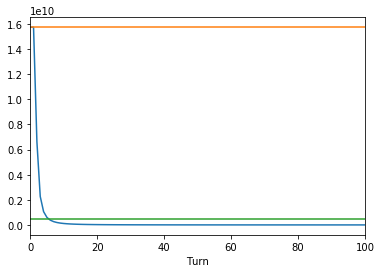

In [1998]:
ibs0.set_index('Turn')['Tp'].plot()
ibs1.set_index('Turn')['Tp'].plot()
ibs2.set_index('Turn')['Tp'].plot()

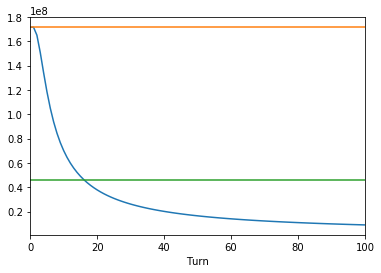

In [1999]:
ibs0.set_index('Turn')['Tex'].plot()
ibs1.set_index('Turn')['Tex'].plot()
ibs2.set_index('Turn')['Tex'].plot()

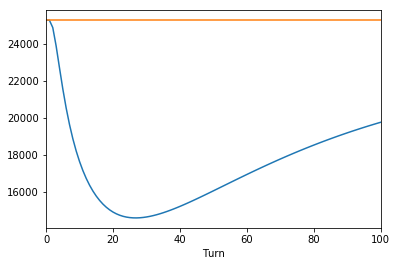

In [1995]:
ibs0.set_index('Turn')['Tey'].plot()
ibs1.set_index('Turn')['Tey'].plot()